In [104]:
import pandas as pd
import numpy as np
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns
import hnswlib
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors

from scipy.stats import zscore

from IPython.core.display import display, HTML, clear_output



warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:90% !important; }</style>"))

In [105]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3404559       10540826          311.95         W   9500  321.0   
1             3404560       10540850           59.00         W  15497  490.0   
2             3404561       10540855           59.00         W   7919  194.0   
3             3404562       10540864          160.50         W  16075  514.0   
4             3404563       10540871          932.00         W  11639  321.0   
...               ...            ...             ...       ...    ...    ...   
172976        3577535       15811047           49.00         W   6550    NaN   
172977        3577536       15811049           39.50         W  10444  225.0   
172978        3577537       15811079           30.95         W  12037  595.0   
172979        3577538       15811088          117.00         W   7826  481.0   
172980        3577539       15811131          279.95         W  15066  170.0   

        card3       card4  card5   card6  ...  V330  V331  V332  V333 V334  \
0       150.0        visa  226.0   debit  ...   NaN   NaN   NaN   NaN  NaN   
1       150.0        visa  226.0   debit  ...   NaN   NaN   NaN   NaN  NaN   
2       150.0  mastercard  166.0   debit  ...   NaN   NaN   NaN   NaN  NaN   
3       150.0  mastercard  102.0  credit  ...   NaN   NaN   NaN   NaN  NaN   
4       150.0        visa  226.0   debit  ...   NaN   NaN   NaN   NaN  NaN   
...       ...         ...    ...     ...  ...   ...   ...   ...   ...  ...   
172976  150.0        visa  226.0   debit  ...   NaN   NaN   NaN   NaN  NaN   
172977  150.0  mastercard  224.0   debit  ...   NaN   NaN   NaN   NaN  NaN   
172978  150.0  mastercard  224.0   debit  ...   NaN   NaN   NaN   NaN  NaN   
172979  150.0  mastercard  224.0   debit  ...   NaN   NaN   NaN   NaN  NaN   
172980  150.0  mastercard  102.0  credit  ...   NaN   NaN   NaN   NaN  NaN   

       V335  V336  V337  V338  V339  
0       NaN   NaN   NaN   NaN   NaN  
1       NaN   NaN   NaN   NaN   NaN  
2       NaN   NaN   NaN   NaN   NaN  
3       NaN   NaN   NaN   NaN   NaN  
4       NaN   NaN   NaN   NaN   NaN  
...     ...   ...   ...   ...   ...  
172976  NaN   NaN   NaN   NaN   NaN  
172977  NaN   NaN   NaN   NaN   NaN  
172978  NaN   NaN   NaN   NaN   NaN  
172979  NaN   NaN   NaN   NaN   NaN  
172980  NaN   NaN   NaN   NaN   NaN  

[172981 rows x 393 columns]

In [106]:
# сначала оставим только те столбцы, которые упоминаются в описании соревнования
cols = ['TransactionID','TransactionDT', 'TransactionAmt', 'ProductCD'] + \
       [f'card{i}' for i in range(1, 7)] + \
       ['addr1', 'addr2'] + \
       ['dist1', 'dist2'] + \
       ['P_emaildomain', 'R_emaildomain'] + \
       [f'C{i}' for i in range(1, 15)] + \
       [f'D{i}' for i in range(1, 16)] + \
       [f'M{i}' for i in range(1, 10)] + \
       [f'V{i}' for i in range(1, 46)]
train_transaction = train_transaction[['isFraud',*cols]]
test_transaction = test_transaction[cols]
train_transaction

isFraud  TransactionID  TransactionDT  TransactionAmt ProductCD  \
0             0        2987000          86400          68.500         W   
1             0        2987001          86401          29.000         W   
2             0        2987002          86469          59.000         W   
3             0        2987003          86499          50.000         W   
4             0        2987004          86506          50.000         H   
...         ...            ...            ...             ...       ...   
417554        0        3404554       10540759         335.000         W   
417555        0        3404555       10540766         160.500         W   
417556        0        3404556       10540775         230.079         C   
417557        0        3404557       10540789         105.000         W   
417558        0        3404558       10540797         226.000         W   

        card1  card2  card3       card4  card5  ...  V36  V37  V38  V39  V40  \
0       13926    NaN  150.0    discover  142.0  ...  NaN  NaN  NaN  NaN  NaN   
1        2755  404.0  150.0  mastercard  102.0  ...  0.0  1.0  1.0  0.0  0.0   
2        4663  490.0  150.0        visa  166.0  ...  1.0  1.0  1.0  0.0  0.0   
3       18132  567.0  150.0  mastercard  117.0  ...  1.0  1.0  1.0  0.0  0.0   
4        4497  514.0  150.0  mastercard  102.0  ...  NaN  NaN  NaN  NaN  NaN   
...       ...    ...    ...         ...    ...  ...  ...  ...  ...  ...  ...   
417554   2538  476.0  150.0        visa  166.0  ...  1.0  2.0  2.0  0.0  0.0   
417555   6019  583.0  150.0        visa  226.0  ...  1.0  1.0  1.0  0.0  0.0   
417556   5059  138.0  200.0        visa  226.0  ...  0.0  1.0  1.0  1.0  1.0   
417557   6697  111.0  150.0        visa  195.0  ...  0.0  1.0  1.0  0.0  0.0   
417558  10112  360.0  150.0        visa  166.0  ...  0.0  1.0  1.0  0.0  0.0   

        V41  V42  V43  V44  V45  
0       NaN  NaN  NaN  NaN  NaN  
1       1.0  0.0  0.0  1.0  1.0  
2       1.0  0.0  0.0  1.0  1.0  
3       1.0  0.0  0.0  1.0  1.0  
4       NaN  NaN  NaN  NaN  NaN  
...     ...  ...  ...  ...  ...  
417554  1.0  0.0  0.0  1.0  1.0  
417555  1.0  0.0  0.0  1.0  1.0  
417556  1.0  1.0  1.0  1.0  1.0  
417557  1.0  0.0  0.0  1.0  1.0  
417558  1.0  0.0  0.0  1.0  1.0  

[417559 rows x 100 columns]

In [107]:
cols = [*([f'id_{i:02d}' for i in range(1, 39)]), 'DeviceType', 'DeviceInfo','TransactionID']
train_identity = train_identity[cols]
test_identity = test_identity[cols]
train_identity

id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  \
0         0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1        -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN    NaN   
2        -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN    0.0   
3        -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN    NaN   
4         0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN    0.0   
...       ...       ...    ...    ...    ...    ...    ...    ...    ...   
110661    0.0     985.0    0.0    0.0    0.0    0.0    NaN    NaN    0.0   
110662    0.0  114486.0    0.0    0.0    0.0    0.0    NaN    NaN    0.0   
110663   -5.0  386272.0    0.0    0.0    6.0  -13.0    NaN    NaN    0.0   
110664   -5.0  818972.0    NaN    NaN    0.0    0.0    NaN    NaN    NaN   
110665  -10.0  265769.0    0.0    0.0    1.0    0.0    NaN    NaN    0.0   

        id_10  ...  id_32      id_33           id_34  id_35 id_36 id_37  \
0         NaN  ...   32.0  2220x1080  match_status:2      T     F     T   
1         NaN  ...   32.0   1334x750  match_status:1      T     F     F   
2         0.0  ...    NaN        NaN             NaN      F     F     T   
3         NaN  ...    NaN        NaN             NaN      F     F     T   
4         0.0  ...   24.0   1280x800  match_status:2      T     F     T   
...       ...  ...    ...        ...             ...    ...   ...   ...   
110661    0.0  ...   24.0   1440x900  match_status:2      T     F     T   
110662    0.0  ...   24.0  2560x1600  match_status:2      T     F     T   
110663    0.0  ...    NaN        NaN             NaN      F     F     T   
110664    NaN  ...    NaN        NaN             NaN      F     F     T   
110665    0.0  ...    NaN        NaN             NaN      F     F     T   

        id_38  DeviceType                     DeviceInfo  TransactionID  
0           T      mobile  SAMSUNG SM-G892A Build/NRD90M        2987004  
1           T      mobile                     iOS Device        2987008  
2           T     desktop                        Windows        2987010  
3           T     desktop                            NaN        2987011  
4           T     desktop                          MacOS        2987016  
...       ...         ...                            ...            ...  
110661      T     desktop                          MacOS        3404525  
110662      T     desktop                        rv:59.0        3404536  
110663      F      mobile           LG-X240 Build/MRA58K        3404546  
110664      F      mobile    ALP-L09 Build/HUAWEIALP-L09        3404547  
110665      F      mobile         SM-A320FL Build/NRD90M        3404556  

[110666 rows x 41 columns]

In [146]:
train_dataset = train_transaction.merge(train_identity,'left','TransactionID')
test_dataset = test_transaction.merge(test_identity,'left','TransactionID')
test_dataset

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3404559       10540826          311.95         W   9500  321.0   
1             3404560       10540850           59.00         W  15497  490.0   
2             3404561       10540855           59.00         W   7919  194.0   
3             3404562       10540864          160.50         W  16075  514.0   
4             3404563       10540871          932.00         W  11639  321.0   
...               ...            ...             ...       ...    ...    ...   
172976        3577535       15811047           49.00         W   6550    NaN   
172977        3577536       15811049           39.50         W  10444  225.0   
172978        3577537       15811079           30.95         W  12037  595.0   
172979        3577538       15811088          117.00         W   7826  481.0   
172980        3577539       15811131          279.95         W  15066  170.0   

        card3       card4  card5   card6  ...  id_31  id_32  id_33  id_34  \
0       150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
1       150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
2       150.0  mastercard  166.0   debit  ...    NaN    NaN    NaN    NaN   
3       150.0  mastercard  102.0  credit  ...    NaN    NaN    NaN    NaN   
4       150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
...       ...         ...    ...     ...  ...    ...    ...    ...    ...   
172976  150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
172977  150.0  mastercard  224.0   debit  ...    NaN    NaN    NaN    NaN   
172978  150.0  mastercard  224.0   debit  ...    NaN    NaN    NaN    NaN   
172979  150.0  mastercard  224.0   debit  ...    NaN    NaN    NaN    NaN   
172980  150.0  mastercard  102.0  credit  ...    NaN    NaN    NaN    NaN   

       id_35 id_36  id_37  id_38  DeviceType  DeviceInfo  
0        NaN   NaN    NaN    NaN         NaN         NaN  
1        NaN   NaN    NaN    NaN         NaN         NaN  
2        NaN   NaN    NaN    NaN         NaN         NaN  
3        NaN   NaN    NaN    NaN         NaN         NaN  
4        NaN   NaN    NaN    NaN         NaN         NaN  
...      ...   ...    ...    ...         ...         ...  
172976   NaN   NaN    NaN    NaN         NaN         NaN  
172977   NaN   NaN    NaN    NaN         NaN         NaN  
172978   NaN   NaN    NaN    NaN         NaN         NaN  
172979   NaN   NaN    NaN    NaN         NaN         NaN  
172980   NaN   NaN    NaN    NaN         NaN         NaN  

[172981 rows x 139 columns]

#### Посмотрим на распределение целевой переменной



доля фрода 0.03525489811020718


<Axes: >

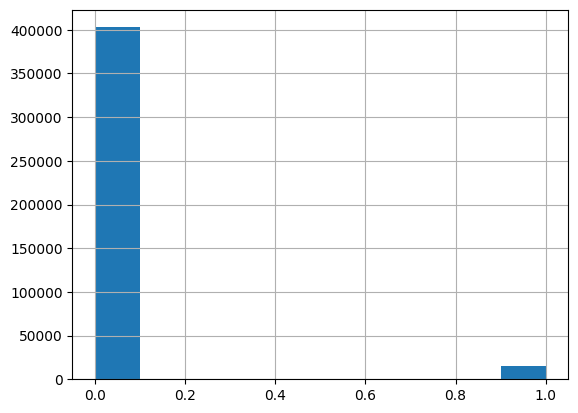

In [147]:
fraud_share = train_dataset.isFraud.sum()/len(train_dataset)
print('доля фрода', fraud_share)
train_transaction.isFraud.hist()


#### При таком дисбалансе как будто и нет никакого смысла пытаться решить проблему оверсемплингом, будем рубить с плеча и представим каждый класс в равной пропорции
##### Но перед этим закодируем категориальные признаки. Сохраним это в отдельные датафреймы так как для бустингов это может ухудшить качество

In [148]:
cat_cols = train_dataset.select_dtypes(include=['category','object']).columns


train_dataset_freq = train_dataset.copy()
test_dataset_freq = test_dataset.copy()
# применяем frequency encoding, для каждого категориального признака
for col in cat_cols:
    freq_encoding = train_dataset_freq[col].value_counts(normalize=True)
    train_dataset_freq[col] = train_dataset_freq[col].map(freq_encoding)
    test_dataset_freq[col] = test_dataset_freq[col].map(freq_encoding)
test_dataset

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3404559       10540826          311.95         W   9500  321.0   
1             3404560       10540850           59.00         W  15497  490.0   
2             3404561       10540855           59.00         W   7919  194.0   
3             3404562       10540864          160.50         W  16075  514.0   
4             3404563       10540871          932.00         W  11639  321.0   
...               ...            ...             ...       ...    ...    ...   
172976        3577535       15811047           49.00         W   6550    NaN   
172977        3577536       15811049           39.50         W  10444  225.0   
172978        3577537       15811079           30.95         W  12037  595.0   
172979        3577538       15811088          117.00         W   7826  481.0   
172980        3577539       15811131          279.95         W  15066  170.0   

        card3       card4  card5   card6  ...  id_31  id_32  id_33  id_34  \
0       150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
1       150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
2       150.0  mastercard  166.0   debit  ...    NaN    NaN    NaN    NaN   
3       150.0  mastercard  102.0  credit  ...    NaN    NaN    NaN    NaN   
4       150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
...       ...         ...    ...     ...  ...    ...    ...    ...    ...   
172976  150.0        visa  226.0   debit  ...    NaN    NaN    NaN    NaN   
172977  150.0  mastercard  224.0   debit  ...    NaN    NaN    NaN    NaN   
172978  150.0  mastercard  224.0   debit  ...    NaN    NaN    NaN    NaN   
172979  150.0  mastercard  224.0   debit  ...    NaN    NaN    NaN    NaN   
172980  150.0  mastercard  102.0  credit  ...    NaN    NaN    NaN    NaN   

       id_35 id_36  id_37  id_38  DeviceType  DeviceInfo  
0        NaN   NaN    NaN    NaN         NaN         NaN  
1        NaN   NaN    NaN    NaN         NaN         NaN  
2        NaN   NaN    NaN    NaN         NaN         NaN  
3        NaN   NaN    NaN    NaN         NaN         NaN  
4        NaN   NaN    NaN    NaN         NaN         NaN  
...      ...   ...    ...    ...         ...         ...  
172976   NaN   NaN    NaN    NaN         NaN         NaN  
172977   NaN   NaN    NaN    NaN         NaN         NaN  
172978   NaN   NaN    NaN    NaN         NaN         NaN  
172979   NaN   NaN    NaN    NaN         NaN         NaN  
172980   NaN   NaN    NaN    NaN         NaN         NaN  

[172981 rows x 139 columns]

In [149]:
# удалим одинаковые строки, оставим только первое вхождение для каждого примера
duplicated_mask = train_dataset.drop('TransactionID',axis=1).duplicated(keep='first') == False
train_dataset = train_dataset[duplicated_mask]
train_dataset_freq = train_dataset_freq[duplicated_mask]
train_dataset

isFraud  TransactionID  TransactionDT  TransactionAmt ProductCD  \
0             0        2987000          86400          68.500         W   
1             0        2987001          86401          29.000         W   
2             0        2987002          86469          59.000         W   
3             0        2987003          86499          50.000         W   
4             0        2987004          86506          50.000         H   
...         ...            ...            ...             ...       ...   
417554        0        3404554       10540759         335.000         W   
417555        0        3404555       10540766         160.500         W   
417556        0        3404556       10540775         230.079         C   
417557        0        3404557       10540789         105.000         W   
417558        0        3404558       10540797         226.000         W   

        card1  card2  card3       card4  card5  ...                    id_31  \
0       13926    NaN  150.0    discover  142.0  ...                      NaN   
1        2755  404.0  150.0  mastercard  102.0  ...                      NaN   
2        4663  490.0  150.0        visa  166.0  ...                      NaN   
3       18132  567.0  150.0  mastercard  117.0  ...                      NaN   
4        4497  514.0  150.0  mastercard  102.0  ...      samsung browser 6.2   
...       ...    ...    ...         ...    ...  ...                      ...   
417554   2538  476.0  150.0        visa  166.0  ...                      NaN   
417555   6019  583.0  150.0        visa  226.0  ...                      NaN   
417556   5059  138.0  200.0        visa  226.0  ...  chrome 65.0 for android   
417557   6697  111.0  150.0        visa  195.0  ...                      NaN   
417558  10112  360.0  150.0        visa  166.0  ...                      NaN   

        id_32      id_33           id_34  id_35 id_36 id_37  id_38  \
0         NaN        NaN             NaN    NaN   NaN   NaN    NaN   
1         NaN        NaN             NaN    NaN   NaN   NaN    NaN   
2         NaN        NaN             NaN    NaN   NaN   NaN    NaN   
3         NaN        NaN             NaN    NaN   NaN   NaN    NaN   
4        32.0  2220x1080  match_status:2      T     F     T      T   
...       ...        ...             ...    ...   ...   ...    ...   
417554    NaN        NaN             NaN    NaN   NaN   NaN    NaN   
417555    NaN        NaN             NaN    NaN   NaN   NaN    NaN   
417556    NaN        NaN             NaN      F     F     T      F   
417557    NaN        NaN             NaN    NaN   NaN   NaN    NaN   
417558    NaN        NaN             NaN    NaN   NaN   NaN    NaN   

        DeviceType                     DeviceInfo  
0              NaN                            NaN  
1              NaN                            NaN  
2              NaN                            NaN  
3              NaN                            NaN  
4           mobile  SAMSUNG SM-G892A Build/NRD90M  
...            ...                            ...  
417554         NaN                            NaN  
417555         NaN                            NaN  
417556      mobile         SM-A320FL Build/NRD90M  
417557         NaN                            NaN  
417558         NaN                            NaN  

[417538 rows x 140 columns]

#### Когда необходимые предобработки сделали, остался вопрос с пропущенными значениями, для каждого из них будем вписывать уникальное число
#### Теперь проведем андерсемплинг и подготовим наборы данных для обучения моделей

In [150]:
def data_preparation(dataset, breakdown_level=3, fill=-np.inf, category='keep'):
    X = dataset.drop(columns=['isFraud'])
    y = dataset['isFraud']
    
    # берем маски классов
    minority_mask = (y == 1)
    majority_mask = (y == 0)
    
    
    n_minority = minority_mask.sum()
    
    # любые попытки отфильтровать самые заполненные строки привели к даталику, поэтому просто оставим рандомный андерсемплинг
    # если на этом этапе отфильтровать loc[X.TransactionID.isin(train_identity.TransactionID)]
    # то тоже получим подозрительно хорошие метрики, так что оставим как есть
    majority_selected = X[majority_mask].sample(n_minority, random_state=42, replace=False)
    
    
    majority_selected_indices = majority_selected.index
    minority_selected_indices = X[minority_mask].index
    selected_indices = majority_selected_indices.union(minority_selected_indices)
    
    # отбираем в нужных пропорциях
    X_resampled = X.loc[selected_indices]
    y_resampled = y.loc[selected_indices]
    
    print("Пропорции до андерсемплинга:")
    print(y.value_counts())
    print("Пропорции после андерсемплинга:")
    print(y_resampled.value_counts())
    
    
    
    # не будем заполнять пропуски какими-то стат. значениями, просто вставим что-то точно уникальное
    for col in X_resampled.columns:
        if X_resampled[col].dtype in ['int64', 'float64']:
            X_resampled[col].fillna(fill, inplace=True)
        if X_resampled[col].dtype in ['object','category']:
            X_resampled[col].fillna('fill', inplace=True)
            X_resampled[col] = X_resampled[col].astype('category')
            
            
    if breakdown_level == 3:
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
        )
        
        X_train, X_validation, y_train, y_validation = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
        )
        
        
        print('y_train_val',y_train_val.value_counts())
        print('y_test',y_test.value_counts() )
        print('y_train',y_train.value_counts())
        print('y_validation',y_validation.value_counts())
        
        return X_train, X_validation, y_train, y_validation, X_test, y_test
        
    elif breakdown_level == 2:
        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
        )
        
        return X_train, X_test, y_train, y_test 
    else:
        return X_resampled, y_resampled
        
X_train, X_validation, y_train, y_validation, X_test, y_test = data_preparation(train_dataset)

Пропорции до андерсемплинга:
isFraud
0    402822
1     14716
Name: count, dtype: int64
Пропорции после андерсемплинга:
isFraud
0    14716
1    14716
Name: count, dtype: int64
y_train_val isFraud
1    11773
0    11772
Name: count, dtype: int64
y_test isFraud
0    2944
1    2943
Name: count, dtype: int64
y_train isFraud
0    8829
1    8829
Name: count, dtype: int64
y_validation isFraud
1    2944
0    2943
Name: count, dtype: int64


##### У нас уже есть сэмпл с которым будем работать, теперь можно посмотреть какие связи есть между признаками и с целевой переменной

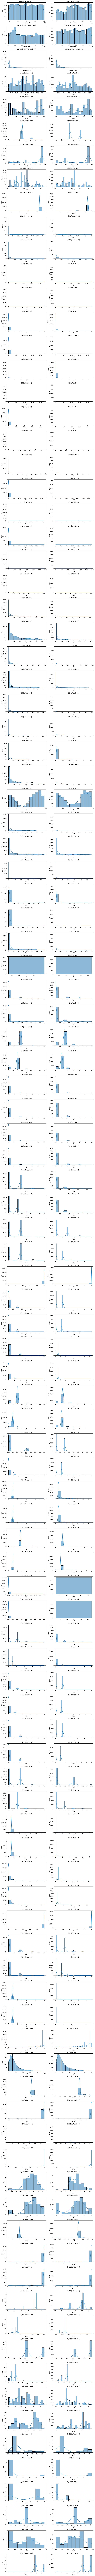

In [10]:
numeric_features = X_train.select_dtypes(['float','int']).columns
list(numeric_features).sort()

fraud_values = [0,1]
n_features = len(numeric_features)

fig, axes = plt.subplots(n_features, len(fraud_values), figsize=(6 * len(fraud_values), 3 * n_features))
for i, feature in enumerate(numeric_features):
    for j, fraud_val in enumerate(fraud_values):
        data = X_train[y_train == fraud_val]
        
        ax = axes[i, j] if n_features > 1 else axes[j]
        sns.histplot(data=data, x=feature, kde=True, ax=ax)
        ax.set_title(f'{feature} (isFraud = {fraud_val})')

plt.tight_layout()
plt.show()


##### Есть несколько распределений признака с очень длинными хвостами, попробуем логарифмировать их чтобы сгруппировать поближе

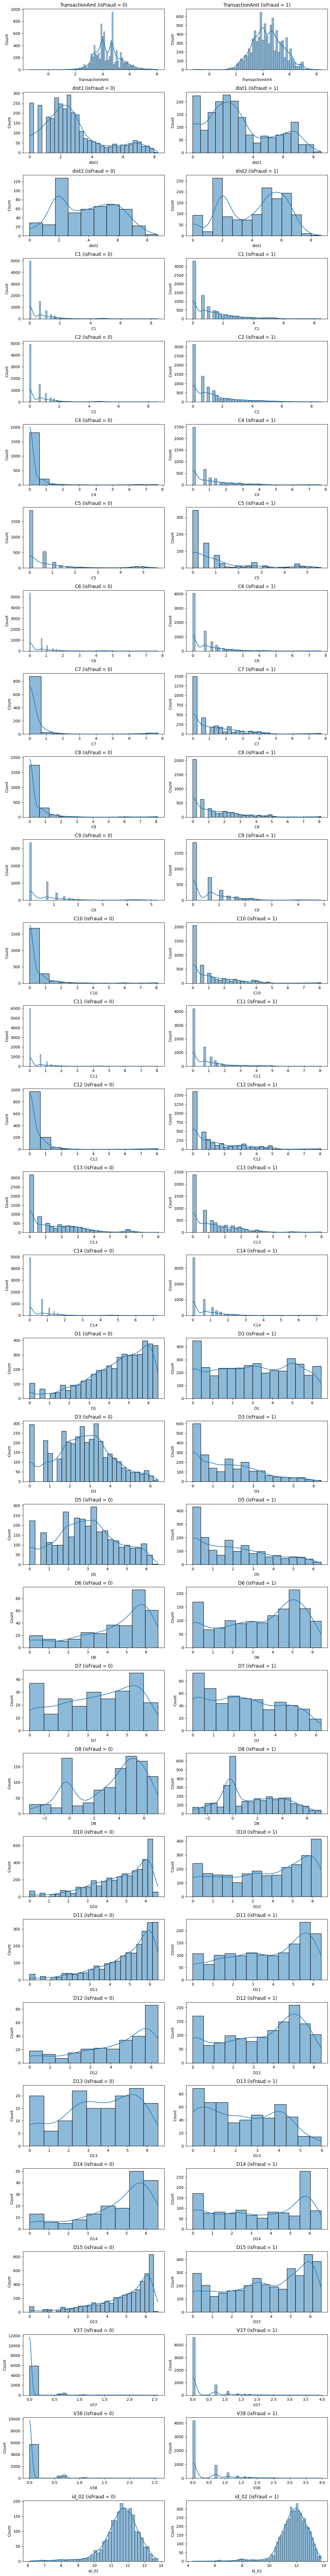

In [11]:
to_log_columns = ['TransactionAmt','dist1','dist2','C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','D1','D3','D5','D6','D7','D8','D10','D11','D12',
'D13','D14','D15','V37','V38','id_02',]

X_log = X_train[to_log_columns].copy()
n_features = len(to_log_columns)

for col in to_log_columns:
    X_log[col] = X_log[col].apply(np.log)

fig, axes = plt.subplots(n_features, len(fraud_values), figsize=(6 * len(fraud_values), 3 * n_features))
for i, feature in enumerate(to_log_columns):
    for j, fraud_val in enumerate(fraud_values):
        data = X_log[y_train == fraud_val]
        
        ax = axes[i, j] if n_features > 1 else axes[j]
        sns.histplot(data=data, x=feature, kde=True, ax=ax)
        ax.set_title(f'{feature} (isFraud = {fraud_val})')

plt.tight_layout()
plt.show()


In [151]:
# заменяем эти признаки в нашем наборе данных
X_log = X_train[to_log_columns].copy()
n_features = len(to_log_columns)

for col in to_log_columns:
    X_log[col] = X_log[col].apply(np.log)
    
for col in to_log_columns:
    train_dataset[col] = train_dataset[col].apply(np.log)
    test_dataset[col] = test_dataset[col].apply(np.log)
    train_dataset_freq[col] = train_dataset_freq[col].apply(np.log)
    test_dataset_freq[col] = test_dataset_freq[col].apply(np.log)


X_train, X_validation, y_train, y_validation, X_test, y_test = data_preparation(train_dataset)

Пропорции до андерсемплинга:
isFraud
0    402822
1     14716
Name: count, dtype: int64
Пропорции после андерсемплинга:
isFraud
0    14716
1    14716
Name: count, dtype: int64
y_train_val isFraud
1    11773
0    11772
Name: count, dtype: int64
y_test isFraud
0    2944
1    2943
Name: count, dtype: int64
y_train isFraud
0    8829
1    8829
Name: count, dtype: int64
y_validation isFraud
1    2944
0    2943
Name: count, dtype: int64


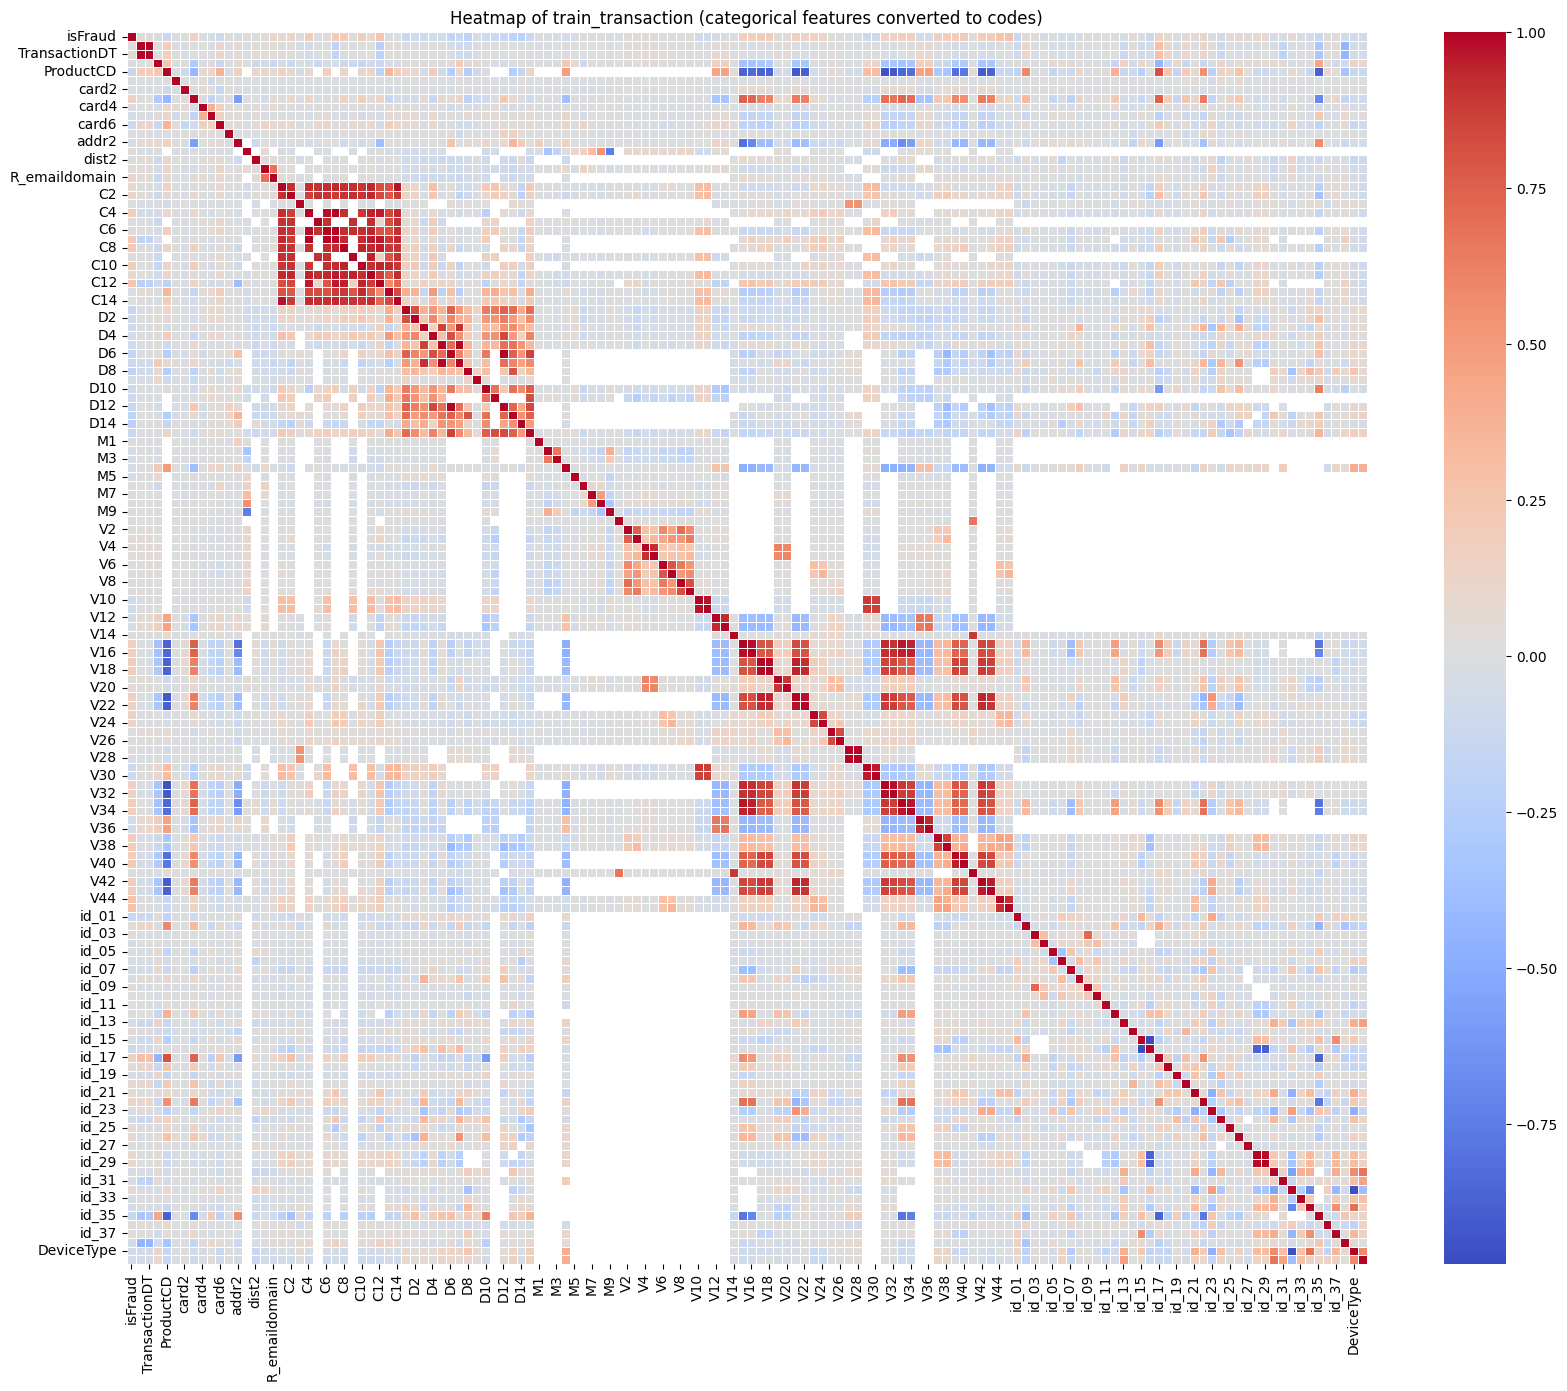

In [152]:
corr_matrix = train_dataset_freq.corr()


plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap of train_transaction (categorical features converted to codes)")
plt.show()

#### Самые коррелирующие признаки это "сгенерированные вручную признаки на основе ранжирования", а временные признаки как правило имеют отрицательную корреляцию.
##### Получается часть предобработки уже сделана вручную и это хорошо, а чем больше времени прошло с момента каких-то операции тем менее вероятно транзакция мошенническая. Также наблюдается сильная связь признаков внутри своих групп. Например "С" признаки сильно связаны между собой, а "V" признаки между собой, тоже справедливо и для "D" признаков. Мы не будем удалять сильно коррелирующие признаки так как мы не будем обучать линейные модели. Многие из признаков очень похожим образом распределены как в нормальных так и фрод транзкциях.
#####  Теперь у нас заполнены пропуски, закодированы категориальные признаки и скорректированы распределения. Попробуем определить аномалии с помощью изоляционного леса. Методы основанные на определении расстояний, на таком датасете просто застрянут в вычислениях при вызове предикта, поэтому я остановлюсь только на одном алгоритме поиска аномалий.

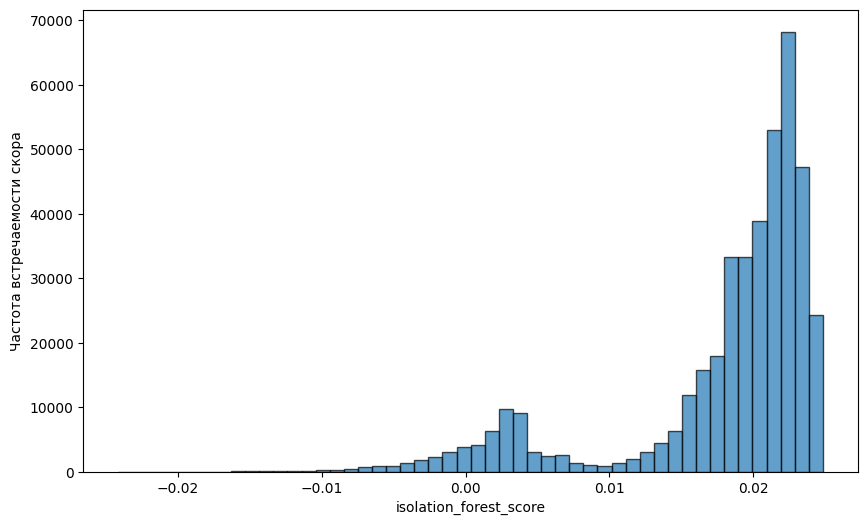

In [153]:

numeric_cols = train_dataset.drop('isFraud', axis=1).select_dtypes(include=[np.number]).columns.tolist()

isolation_forest = IsolationForest(random_state=42,contamination=fraud_share)
isolation_forest.fit(train_dataset[numeric_cols])

train_dataset['isolation_forest_score'] = isolation_forest.decision_function(train_dataset[numeric_cols])
train_dataset_freq['isolation_forest_score'] = isolation_forest.decision_function(train_dataset[numeric_cols])

# по умолчанию флаг будет -1 и 1, сразу поменяем метки 
train_dataset['isolation_forest_flag'] = (isolation_forest.predict(train_dataset[numeric_cols]) -1) / -2
train_dataset_freq['isolation_forest_flag'] = (isolation_forest.predict(train_dataset[numeric_cols]) -1) / -2

test_dataset['isolation_forest_score'] = isolation_forest.decision_function(test_dataset[numeric_cols])
test_dataset['isolation_forest_flag'] = (isolation_forest.predict(test_dataset[numeric_cols]) -1) / 2

test_dataset_freq['isolation_forest_score'] = isolation_forest.decision_function(test_dataset[numeric_cols])
test_dataset_freq['isolation_forest_flag'] = (isolation_forest.predict(test_dataset[numeric_cols]) -1) / 2

# посмотрим как распределены скоры и где можно было бы провести границу аномалий
plt.figure(figsize=(10, 6))
plt.hist(train_dataset['isolation_forest_score'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('isolation_forest_score')
plt.ylabel('Частота встречаемости скора')
plt.show()


### Изоляционный лес сделал свою часть работы, посмотрим его результат на тесте

In [154]:
from sklearn.linear_model import LogisticRegression

X_train, X_validation, y_train, y_validation, X_test, y_test = data_preparation(train_dataset)

lr = LogisticRegression()
lr.fit(train_dataset[['isolation_forest_score']], train_dataset['isFraud'])
p_anomaly_calibrated = lr.predict_proba(test_dataset[['isolation_forest_score']])[:, 1]
p_anomaly_calibrated_train = lr.predict_proba(X_train[['isolation_forest_score']])[:, 1]
print('roc_auc с откалиброванной вероятностью на трейне',roc_auc_score(y_train,p_anomaly_calibrated_train))

sub = pd.DataFrame({'TransactionID': test_dataset['TransactionID'], 'isFraud': p_anomaly_calibrated}) 
sub.to_csv('submission_isolation_forest.csv', index=False)
sub

Пропорции до андерсемплинга:
isFraud
0    402822
1     14716
Name: count, dtype: int64
Пропорции после андерсемплинга:
isFraud
0    14716
1    14716
Name: count, dtype: int64
y_train_val isFraud
1    11773
0    11772
Name: count, dtype: int64
y_test isFraud
0    2944
1    2943
Name: count, dtype: int64
y_train isFraud
0    8829
1    8829
Name: count, dtype: int64
y_validation isFraud
1    2944
0    2943
Name: count, dtype: int64
roc_auc с откалиброванной вероятностью на трейне 0.6945618543776615


TransactionID   isFraud
0             3404559  0.036264
1             3404560  0.028935
2             3404561  0.029626
3             3404562  0.039253
4             3404563  0.025858
...               ...       ...
172976        3577535  0.039313
172977        3577536  0.025858
172978        3577537  0.024215
172979        3577538  0.027039
172980        3577539  0.047119

[172981 rows x 2 columns]

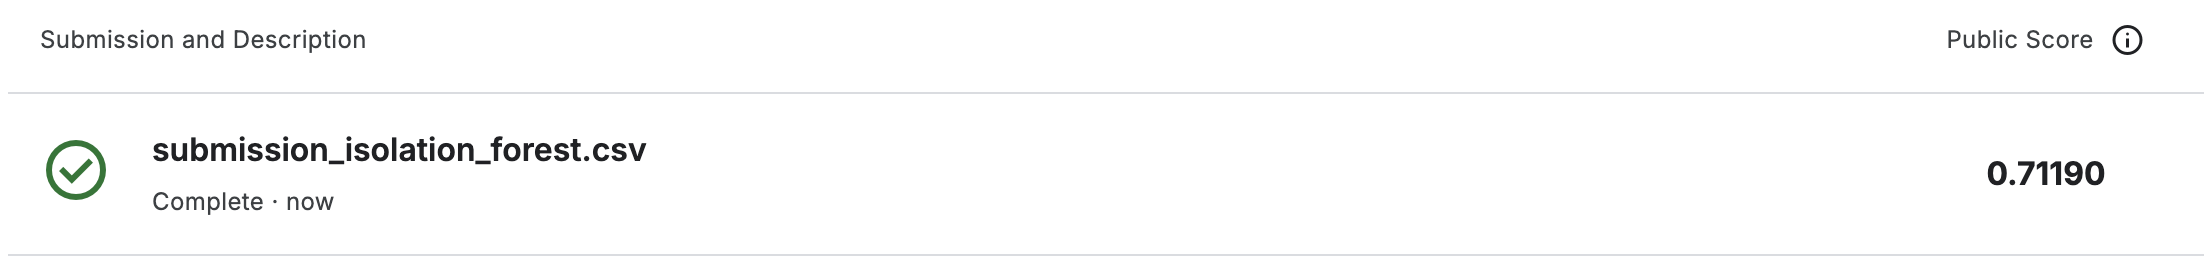

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

##### Выводы 
Исходный набор данных содержал категориальные признаки, их мы закодировали с помощью frequency encoder. Пропуски заполнили значением -np.inf, некоторые логнормальные распределения признаков и просто распределения с длинными хвостами мы логорифмировали и сделали их распределение ближе к нормальному. Полностью одинаковые строки мы удалили, оставив только первое вхождение. На оставшихся данных обучили изоляционный лес чтобы предсказывать вероятность аномалий и этот лес, после калибровки вероятностей даже показывает результат 0.71.

У некоторых признаков наблюдается сильная корреляция, но так как мы не будем использовать линейные модели то и удалять эти признаки необходимости нет.

### Начало положено! Теперь отберем признаки и посмотрим качество на бустингах



ROC-AUC validation: 0.8580
F1-Score validation: 0.7671
ROC-AUC test: 0.8585
F1-Score test: 0.7703


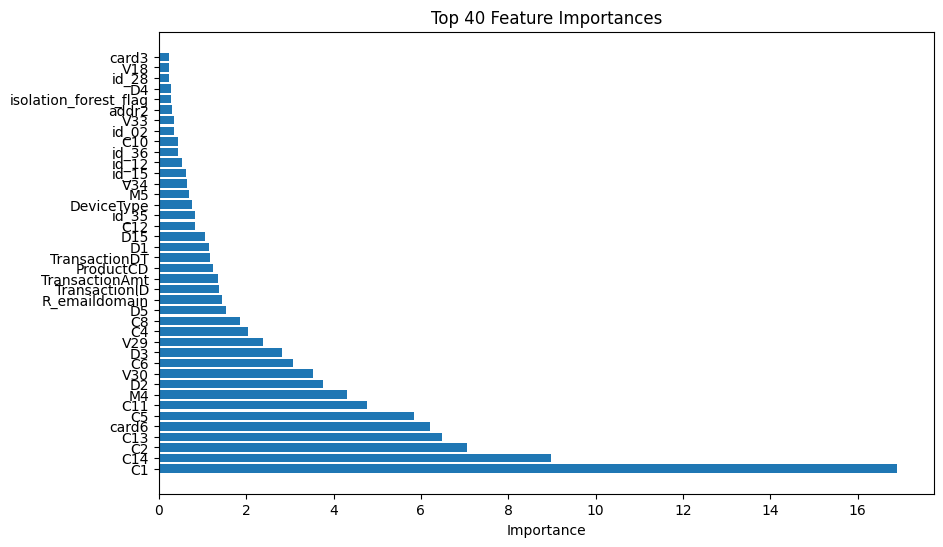

In [155]:
# теперь посмотрим обучим модель с простыми гиперпараметрами
def get_feature_importances(X_train, X_validation, y_train, y_validation, X_test, y_test):

    # разделим на валидацию, трейн и тест
    categorical_features_indices = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
    test_pool = Pool(data=X_validation, label=y_validation, cat_features=categorical_features_indices)
    
    model = CatBoostClassifier(
        iterations=100,  
        learning_rate=0.01,  
        depth=6,  
        random_state=42,
        verbose=False # все что надо мы итак увидим на метриках
    )
    
    model.fit(train_pool, eval_set=test_pool)
    
    # делаем предикты на валидации и тесте
    y_val_pred_proba = model.predict_proba(X_validation)[:, 1]
    y_val_pred = model.predict(X_validation)
    
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    y_test_pred = model.predict(X_test)
    
    # считаем что получилось
    roc_auc_validation = roc_auc_score(y_validation, y_val_pred_proba)
    f1_validation = f1_score(y_validation, y_val_pred)
    
    roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
    f1_test = f1_score(y_test, y_test_pred)
    
    #  смотрим что получилось
    print(f"\n\nROC-AUC validation: {roc_auc_validation:.4f}")
    print(f"F1-Score validation: {f1_validation:.4f}")
    
    print(f"ROC-AUC test: {roc_auc_test:.4f}")
    print(f"F1-Score test: {f1_test:.4f}")
    
    feature_importances = model.get_feature_importance()
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    })
    
    # Сортируем признаки по убыванию важности
    importance_df = importance_df.sort_values('Importance', ascending=False)

    n_features = 40
    top_features = importance_df.head(n_features)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Top {n_features} Feature Importances')
    plt.show()
    
    return importance_df

train_transaction_top_features = get_feature_importances(X_train, X_validation, y_train, y_validation, X_test, y_test)

### Для первой итерации получилось весьма прилично, теперь отберем только важные признаки и еще раз измерим качество чтобы убедиться, что ничего не потеряли
##### Но я удалю 'TransactionID','TransactionDT' так как сами по себе эти признаки ничего не говорят, но если у нас не очень равномерный андерсемплинг и эти признаки тоже дают протечку

Пропорции до андерсемплинга:
isFraud
0    402822
1     14716
Name: count, dtype: int64
Пропорции после андерсемплинга:
isFraud
0    14716
1    14716
Name: count, dtype: int64
y_train_val isFraud
1    11773
0    11772
Name: count, dtype: int64
y_test isFraud
0    2944
1    2943
Name: count, dtype: int64
y_train isFraud
0    8829
1    8829
Name: count, dtype: int64
y_validation isFraud
1    2944
0    2943
Name: count, dtype: int64


ROC-AUC validation: 0.8566
F1-Score validation: 0.7724
ROC-AUC test: 0.8573
F1-Score test: 0.7727


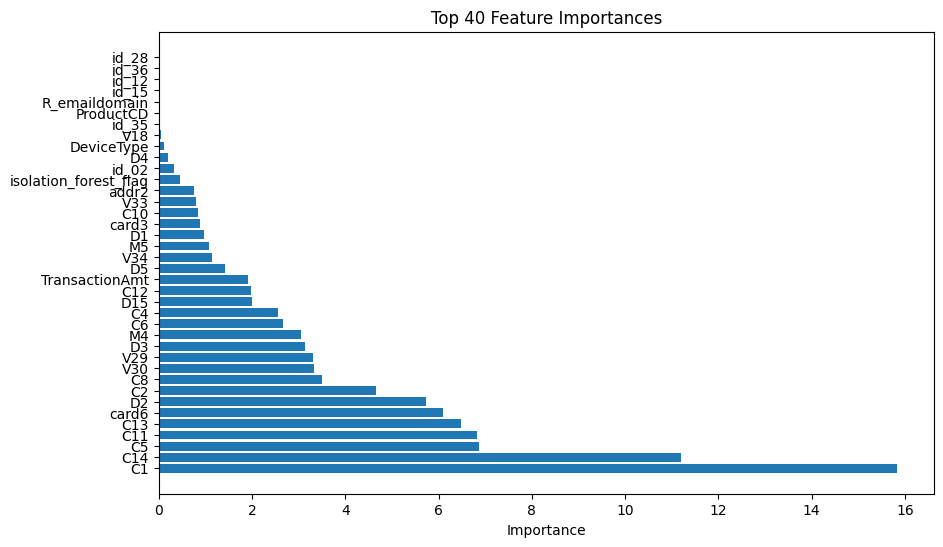

In [156]:
selected_features_transaction = train_transaction_top_features.Feature.tolist()[:40]
X_train, X_validation, y_train, y_validation, X_test, y_test = data_preparation(train_dataset[['isFraud',*selected_features_transaction]].drop(['TransactionID','TransactionDT'],axis=1))
train_transaction_top_features_final = get_feature_importances(
    X_train, X_validation, y_train, y_validation, X_test, y_test
).Feature.tolist()[:40]


#### Мы получили практически такое же качество но всего на 40 признаках, это значит что большая часть информации представлена в этих признаках, но мы попробуем использовать и другие гиперпараметры, поэтому удалять оставшиеся признаки пока не будем, за исключением 'TransactionID','TransactionDT'
##### Использовать будем CatBoostClassifier,LGBMClassifier и RandomForestClassifier.  Бустинги используются здесь по причине того, что многие из признаков распределены похожим образом в обоих классах и по всей видимости нам необходимо уловить нелинейные зависимости.  Случайный лес здесь используется из соображений того, чтобы проверить работоспособность тоже нелинейной модели, но с другим методом принятия решений.

In [157]:
# Собираем данные для обучения с помощью грид серч, валидационных датафреймов в этом случае нам не надо так как будем использовать кросс валидацию
# но сделаем еще разделение на трейн и валидацию чтобы подавать её для обучения модели после того как будут известны лучшие параметры

X_full, y_full = data_preparation(train_dataset.drop(['TransactionID','TransactionDT'],axis=1), breakdown_level=1)
X_train, X_validation, y_train, y_validation  = data_preparation(train_dataset.drop(['TransactionID','TransactionDT'],axis=1), breakdown_level=2)

Пропорции до андерсемплинга:
isFraud
0    402822
1     14716
Name: count, dtype: int64
Пропорции после андерсемплинга:
isFraud
0    14716
1    14716
Name: count, dtype: int64
Пропорции до андерсемплинга:
isFraud
0    402822
1     14716
Name: count, dtype: int64
Пропорции после андерсемплинга:
isFraud
0    14716
1    14716
Name: count, dtype: int64


In [158]:
cat_features = list(X_train.select_dtypes(['object','category']).columns)
start_time = time.time() 

model = CatBoostClassifier(
    cat_features=cat_features,
    verbose=False,
    random_state=42
)

param_grid = {
    'depth': [4,8,10],
    'learning_rate': [0.1,0.01],
    'iterations': [50,150,300]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=10
)

grid_search.fit(X_full, y_full)

print("Best parameters:", grid_search.best_params_)
print("Best roc_auc score (CV):", grid_search.best_score_)

best_model = CatBoostClassifier(
    cat_features=cat_features,
    verbose=False,
    random_state=42,
    **grid_search.best_params_
)

best_model.fit(X_train, y_train,
    eval_set=(X_validation, y_validation))


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Лучший результат был получен за : {elapsed_time:.4f} секунд")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'depth': 10, 'iterations': 300, 'learning_rate': 0.1}
Best roc_auc score (CV): 0.9176679834993499
Лучший результат был получен за : 385.2575 секунд


In [160]:
for col in test_dataset.columns:
    if test_dataset[col].dtype in ['int64', 'float64']:
        test_dataset[col].fillna(-np.inf, inplace=True)
    if test_dataset[col].dtype in ['object','category']:
        test_dataset[col].fillna('fill', inplace=True)
        test_dataset[col] = test_dataset[col].astype('category')

predictions = best_model.predict_proba(test_dataset.drop(['TransactionID','TransactionDT'],axis=1))[:, 1]
sub = pd.DataFrame({'TransactionID': test_dataset['TransactionID'], 'isFraud': predictions}) 
sub.to_csv('submission_catboost.csv', index=False)

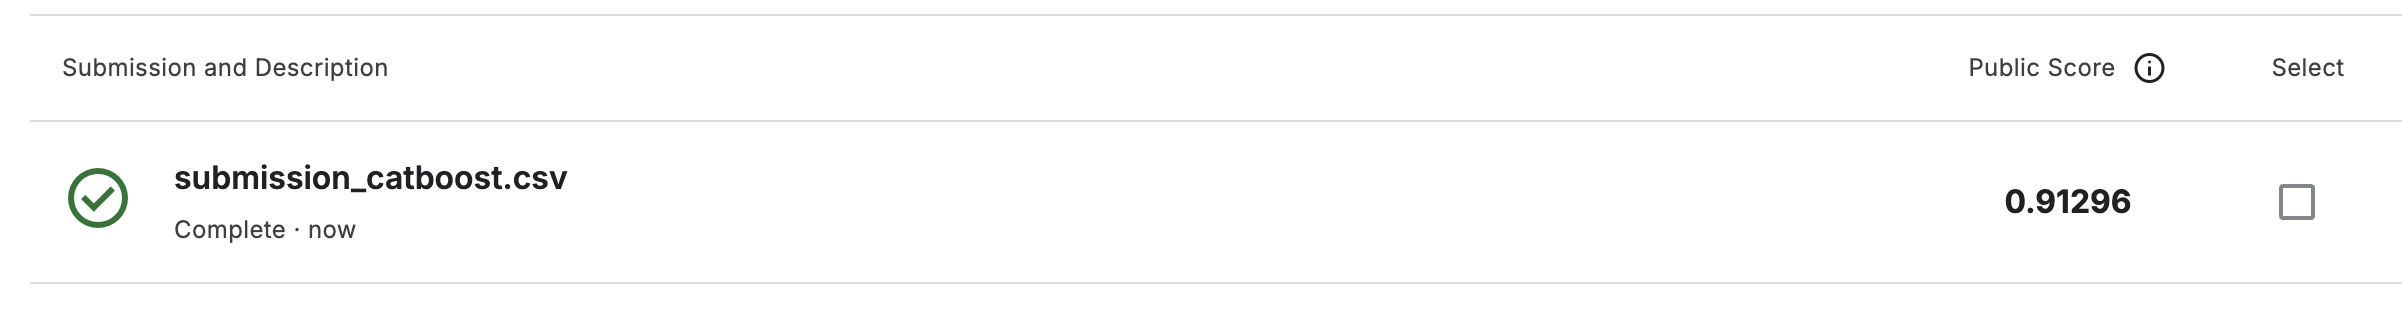

In [36]:
model = LGBMClassifier(random_state=42)

param_grid = {
    'depth': [4,8,10],
    'learning_rate': [0.1,0.01],
    'iterations': [50,150,300]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=10)
grid_search.fit(X_full, y_full)

print("Best parameters:", grid_search.best_params_)
print("Best roc_auc score (CV):", grid_search.best_score_)

best_model = LGBMClassifier(random_state=42, **grid_search.best_params_)
best_model.fit(X_train, y_train,
    eval_set=(X_validation, y_validation))

predictions = best_model.predict_proba(test_dataset[X_full.columns])[:, 1]
sub = pd.DataFrame({'TransactionID': test_dataset['TransactionID'], 'isFraud': predictions})
sub.to_csv('submission_lightgbm.csv', index=False)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 2/18] START depth=4, iterations=50, learning_rate=0.01.................
[CV 1/5; 2/18] END depth=4, iterations=50, learning_rate=0.01;, score=nan total time=   0.0s
[CV 2/5; 3/18] START depth=4, iterations=150, learning_rate=0.1.................
[CV 2/5; 3/18] END depth=4, iterations=150, learning_rate=0.1;, score=nan total time=   0.0s
[CV 2/5; 4/18] START depth=4, iterations=150, learning_rate=0.01................
[CV 2/5; 4/18] END depth=4, iterations=150, learning_rate=0.01;, score=nan total time=   0.0s
[CV 4/5; 4/18] START depth=4, iterations=150, learning_rate=0.01................
[CV 4/5; 4/18] END depth=4, iterations=150, learning_rate=0.01;, score=nan total time=   0.0s
[CV 1/5; 5/18] START depth=4, iterations=300, learning_rate=0.1.................
[CV 1/5; 5/18] END depth=4, iterations=300, learning_rate=0.1;, score=nan total time=   0.0s
[CV 1/5; 6/18] START depth=4, iterations=300, learning_rate=0.01...

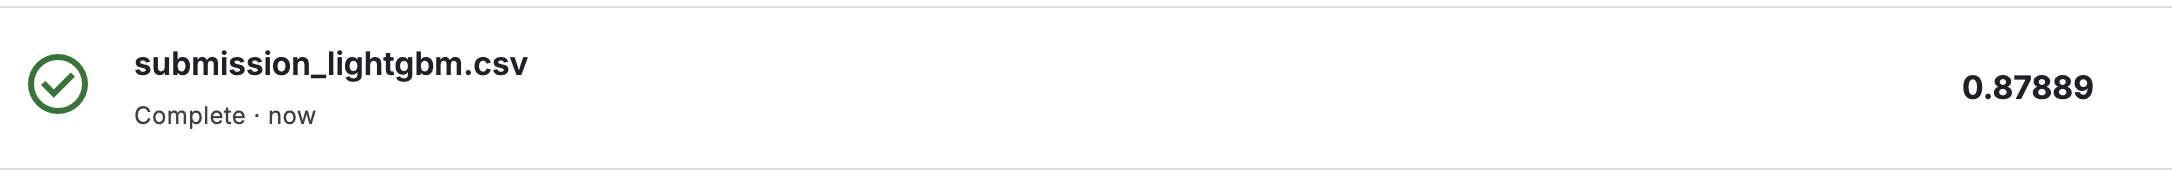

In [34]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'max_depth': [4, 8, 12],
    'n_estimators': [50, 150, 400]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=10)
grid_search.fit(X_full.replace(-np.inf,-9999), y_full)

print("Best parameters:", grid_search.best_params_)
print("Best roc_auc score (CV):", grid_search.best_score_)

best_model = RandomForestClassifier(random_state=42, **grid_search.best_params_, n_jobs=-1)
best_model.fit(X_full.replace(-np.inf,-9999), y_full)

predictions = best_model.predict_proba(test_dataset[X_full.columns].replace(-np.inf,-9999))
sub = pd.DataFrame({'TransactionID': test_dataset['TransactionID'], 'isFraud': predictions})
sub.to_csv('submission_randomforest.csv', index=False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 12, 'n_estimators': 400}
Best roc_auc score (CV): 0.8926522362129623


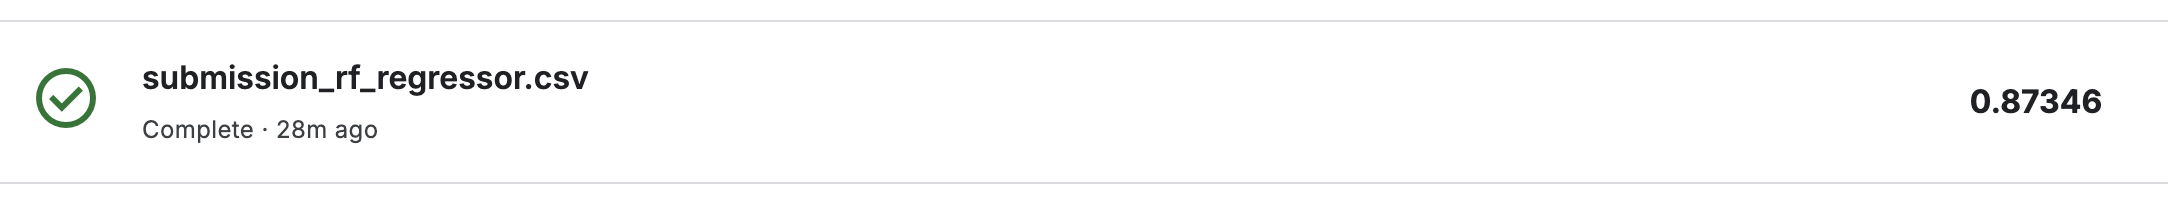

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [171]:
pd.DataFrame([['CatBoost',0.91766,0.91296],
              ['LightGBM',0.90633,0.87889],
              ['RandomForest',0.89265,0.87346]],
            columns=['model','cross-validation','leaderbord'])

model  cross-validation  leaderbord
0      CatBoost           0.91766     0.91296
1      LightGBM           0.90633     0.87889
2  RandomForest           0.89265     0.87346

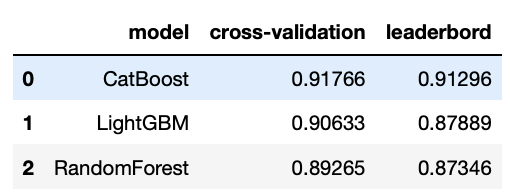

### Лучшим себя показал CatBoost, при этом обучался он значительно дольше остальных моделей. Попробуем подобрать чуть потяжелее параметры, но уже без перебора по сетке и сделать предсказание с помощью бэггинга.

In [ ]:
X_train, X_validation, y_train, y_validation, X_test, y_test = data_preparation(train_dataset.drop(['TransactionID','TransactionDT'],axis=1))

cat_features = list(X_train.select_dtypes(['object','category']).columns)

catboost = CatBoostClassifier(
    cat_features=cat_features,
    verbose=0,
    random_state=42,
    depth=12,
    iterations=800,
    learning_rate= 0.1
    
)
catboost.fit(X_train, y_train,
    eval_set=( X_validation, y_validation))


lgbm = LGBMClassifier(
    verbose=0,
    random_state=42,
    depth=12,
    iterations=800,
    learning_rate= 0.1
)
lgbm.fit(X_train, y_train,
    eval_set=(X_validation, y_validation))



cat_pred = catboost.predict_proba(X_test)[:, 1]
lgbm_pred = lgbm.predict_proba(X_test)[:, 1]
roc_auc_cat = roc_auc_score(y_test, cat_pred)
roc_auc_lgbm = roc_auc_score(y_test, lgbm_pred)



X_train, X_validation, y_train, y_validation, X_test, y_test = data_preparation(train_dataset_freq.drop(['TransactionID','TransactionDT'],axis=1))

rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=12, n_estimators=800)
rf.fit(X_train.replace(-np.inf,-9999), y_train,)
rf_pred = rf.predict_proba(X_test.replace(-np.inf,-9999))[:, 1]

rf.fit(X_train.replace(-np.inf,-9999), y_train,)
roc_auc_rf = roc_auc_score(y_test, rf_pred)

print(f"ROC-AUC catboost: {roc_auc_cat:.4f}")
print(f"ROC-AUC lgbm: {roc_auc_lgbm:.4f}")
print(f"ROC-AUC rf: {roc_auc_rf:.4f}")

In [170]:
final_proba = 0.45 * cat_pred + 0.35 * lgbm_pred + 0.2 * rf_pred
final_roc_auc = roc_auc_score(y_test,final_proba)
print('final_roc_auc при использовании бэггинга:',final_roc_auc)

final_roc_auc при использовании бэггинга: 0.9309813309769682


In [183]:
cat_pred = catboost.predict_proba(test_dataset[X_train.columns])[:, 1]
lgbm_pred = lgbm.predict_proba(test_dataset.drop(['TransactionID','TransactionDT'],axis=1))[:, 1]
rf_pred = rf.predict_proba(test_dataset_freq)[:, 1]


final_proba = 0.45 * cat_pred + 0.35 * lgbm_pred + 0.2 * rf_pred
sub = pd.DataFrame({'TransactionID': test_dataset['TransactionID'], 'isFraud': final_proba})
sub.to_csv('submission_bagging.csv', index=False)

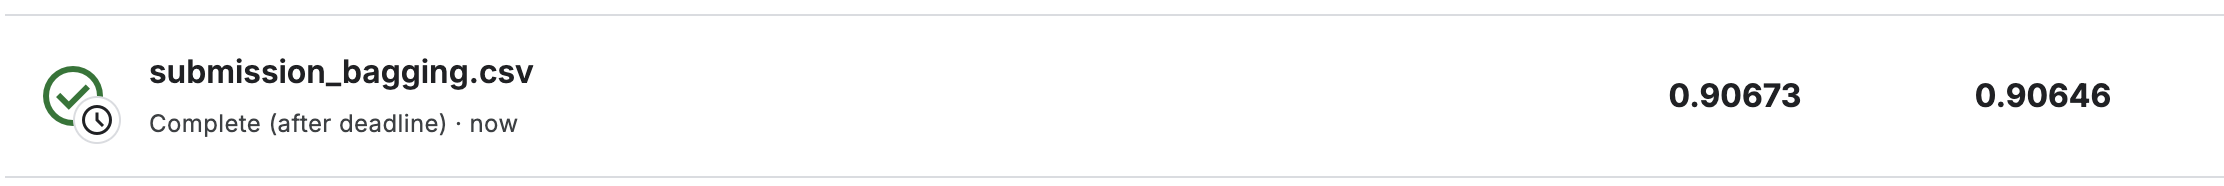

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [39]:
pd.DataFrame([['IsolationForest',0.69456,0.71190]],
            columns=['model','roc_auc_validation','leaderbord'])

model  roc_auc_validation  leaderbord
0  IsolationForest             0.69456      0.7119

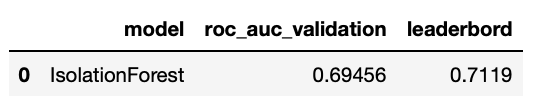

#### Как упоминалось ранее на датасете  такого размера способы определения аномалий методом оценки расстояния обречены на крайне длительные вычисления. Я остановился только на изоляционном лесе и он показал приемлемый результат за минимальное время. Для самостоятельного подхода это разумеется не годится, но этот признак попадает в топ важности по оценке CatBoost, хоть и не занимает первые места.

### Далее построим предсказания с использованием автоМЛ 

In [198]:
from autogluon.tabular import TabularPredictor

# переопределим наборы данных
X_train, X_validation, y_train, y_validation, X_test, y_test = data_preparation(train_dataset.drop(['TransactionID','TransactionDT'],axis=1))


X_train['isFraud'] = y_train
X_validation['isFraud'] = y_validation
X_test['isFraud'] = y_test

X_train = X_train.replace(-np.inf,-9999)
X_validation = X_validation.replace(-np.inf,-9999)
X_test = X_test.replace(-np.inf,-9999)

predictor = TabularPredictor(label='isFraud', eval_metric='roc_auc').fit(
    X_train,
    tuning_data=X_validation,
    time_limit=600
)



No path specified. Models will be saved in: "AutogluonModels/ag-20250316_145619"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:24 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T6030
CPU Count:          11
Memory Avail:       3.90 GB / 18.00 GB (21.7%)
Disk Space Avail:   251.12 GB / 460.43 GB (54.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy

Пропорции до андерсемплинга:
isFraud
0    402822
1     14716
Name: count, dtype: int64
Пропорции после андерсемплинга:
isFraud
0    14716
1    14716
Name: count, dtype: int64
y_train_val isFraud
1    11773
0    11772
Name: count, dtype: int64
y_test isFraud
0    2944
1    2943
Name: count, dtype: int64
y_train isFraud
0    8829
1    8829
Name: count, dtype: int64
y_validation isFraud
1    2944
0    2943
Name: count, dtype: int64


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 4 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Unused Original Features (Count: 1): ['V28']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 1 | ['V28']
	Types of features in original data (raw dtype, special dtypes):
		(

[1000]	valid_set's binary_logloss: 0.307159
[2000]	valid_set's binary_logloss: 0.291035
[3000]	valid_set's binary_logloss: 0.292003


	0.9497	 = Validation score   (roc_auc)
	22.12s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 577.15s of the 577.15s of remaining time.


[1000]	valid_set's binary_logloss: 0.286606


	0.95	 = Validation score   (roc_auc)
	8.11s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestGini ... Training model for up to 568.96s of the 568.96s of remaining time.
	0.9322	 = Validation score   (roc_auc)
	0.89s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: RandomForestEntr ... Training model for up to 567.96s of the 567.96s of remaining time.
	0.9335	 = Validation score   (roc_auc)
	0.95s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 566.89s of the 566.89s of remaining time.
	0.9506	 = Validation score   (roc_auc)
	186.58s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesGini ... Training model for up to 380.24s of the 380.24s of remaining time.
	0.92	 = Validation score   (roc_auc)
	0.54s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesEntr ... Training model for up to 379.56s of the 379.56s of remaining time.
	0.9203	 

In [203]:
predictions = predictor.predict_proba(X_test)[1]
print(roc_auc_score(y_test,predictions))
predictions = predictor.predict_proba(test_dataset.replace(-np.inf,-9999))[1]
sub = pd.DataFrame({'TransactionID': test_dataset['TransactionID'], 'isFraud': predictions})
sub.to_csv('submission_autoML.csv', index=False)

0.9476009418997178


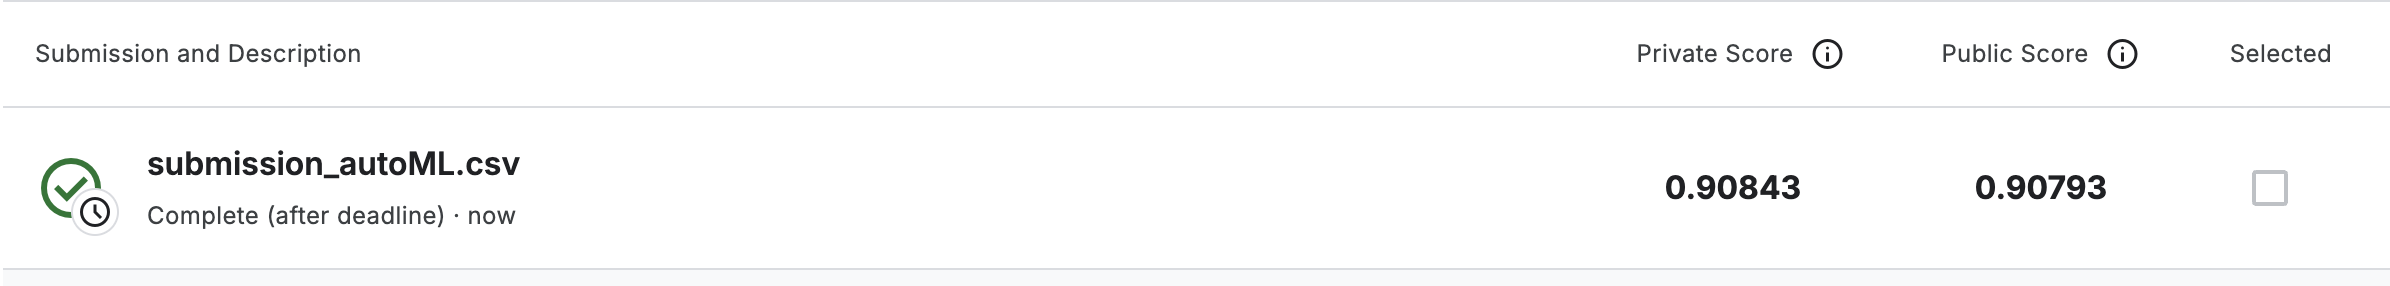

In [192]:

predictor = TabularPredictor(label='isFraud', eval_metric='roc_auc').fit(
    train_dataset.drop(['TransactionID','TransactionDT'],axis=1),
    time_limit=800
)


No path specified. Models will be saved in: "AutogluonModels/ag-20250316_135948"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:24 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T6030
CPU Count:          11
Memory Avail:       4.00 GB / 18.00 GB (22.2%)
Disk Space Avail:   251.51 GB / 460.43 GB (54.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy

[1000]	valid_set's binary_logloss: 0.0604532
[2000]	valid_set's binary_logloss: 0.0515802
[3000]	valid_set's binary_logloss: 0.0472173
[4000]	valid_set's binary_logloss: 0.0445652
[5000]	valid_set's binary_logloss: 0.0429864
[6000]	valid_set's binary_logloss: 0.0421315
[7000]	valid_set's binary_logloss: 0.0418433
[8000]	valid_set's binary_logloss: 0.0419106


	0.9743	 = Validation score   (roc_auc)
	85.78s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 708.61s of the 708.61s of remaining time.


[1000]	valid_set's binary_logloss: 0.0528802
[2000]	valid_set's binary_logloss: 0.0459295
[3000]	valid_set's binary_logloss: 0.0418547
[4000]	valid_set's binary_logloss: 0.0405362
[5000]	valid_set's binary_logloss: 0.0399107
[6000]	valid_set's binary_logloss: 0.0401806


	0.9723	 = Validation score   (roc_auc)
	64.25s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: RandomForestGini ... Training model for up to 644.15s of the 644.15s of remaining time.
		Input X contains infinity or a value too large for dtype('float32').
Detailed Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/autogluon/core/trainer/abstract_trainer.py", line 2106, in _train_and_save
    model = self._train_single(**model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1993, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, total_resources=total_resources, **model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.1

In [193]:
predictions = predictor.predict_proba(X_test)[1]
roc_auc_score(y_test,predictions)

0.9183851188893319

In [196]:
predictions = predictor.predict_proba(test_dataset)[1]
sub = pd.DataFrame({'TransactionID': test_dataset['TransactionID'], 'isFraud': predictions})
sub.to_csv('submission_autoML.csv', index=False)

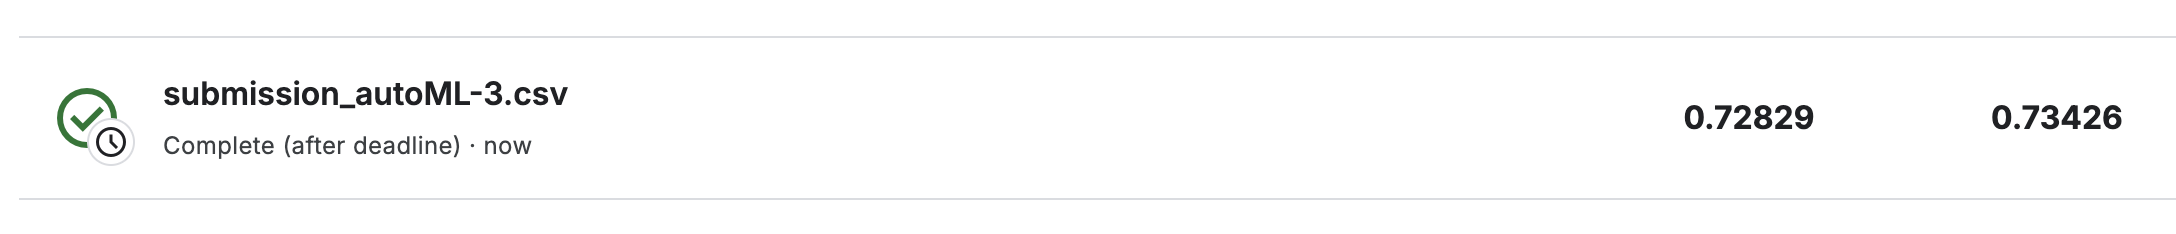

##### Мы обучали автоМЛ на тренировочной + валидационной выборках. На тестовой результат был 0.947, но при отправке сабмита мы получаем 0.90. В любом случае совсем небольшой блок кода с выполнением за 4 минуты достиг хорошей точности.  Однако резкое падение точности, которого не было в случаях с обычными моделями нельзя оставлять без внимания.Списать такое падение точности просто на переобучение не выйдет так как мы подавали трей+валидация, а проверяли уже непосредственно на тесте. Вероятно есть некоторое расхождение в природе данных между тренировочный датасетом и датасетом для сабмита, и то, что модель могла использовать на трейне как показатель фрода, на самом деле таковым показателем не является.

##### При попытке загрузить полный датасет, без андерсемплинга мы получили падение точности до 0.72. Очевидно что с дисбалансом классов автоМЛ решение не справляется.
##### Итоговая табличка с метриками на валидации и в лидерборде представлена ниже:

In [214]:
pd.DataFrame([['1','CatBoost',0.91766,0.91296],
              ['2','UnderSampled_autoML',0.94760,0.90793],
              ['3','Bagging',0.93098,0.90646],
              ['4','LightGBM',0.90633,0.87889],
              ['5','RandomForest',0.89265,0.87346],
              ['6','Full_dataset_autoML',0.918385,0.73426],
              ['7','IsolationForest',0.69456,0.71190]],
            columns=['rating','model','cross-validation','leaderbord'])

rating                model  cross-validation  leaderbord
0      1             CatBoost          0.917660     0.91296
1      2  UnderSampled_autoML          0.947600     0.90793
2      3              Bagging          0.930980     0.90646
3      4             LightGBM          0.906330     0.87889
4      5         RandomForest          0.892650     0.87346
5      6  Full_dataset_autoML          0.918385     0.73426
6      7      IsolationForest          0.694560     0.71190

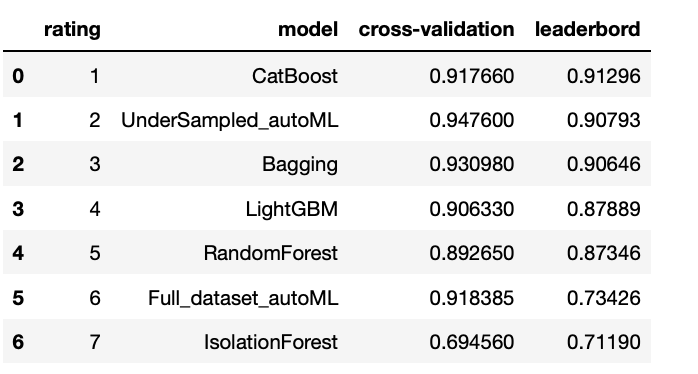

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

#### Вся работа в ноутбуке была проведена на локальном компьютере. Так как лучший результат был получен на модели CatBoost, то время я измерял на переборе гиперпараметров и обучении лучшей модели. В случае с локальной машиной результат был получен за 385.2575. При выполнении этого ноутбука в среде Google Colab мне пришлось сократить в гиперпараметрах значение 'depth' до списка [4,8], так как с большими значениями выполнение подбора просто не заканчивалось. С уменьшеным списком результат был получен за 1119.84 секунд. Причины такого длительного выполнения, конечно, могут быть связаны с разными версиями библиотек, но основная проблема в том что колаб работает с 2 доступными CPU ядрами, а на локальной машине 11, не смотря на то что  объем доступной RAM почти в два раза больше в колабе. Ниже вызов CPU и RAM локально и в колабе.

In [208]:
import multiprocessing
print(multiprocessing.cpu_count())

11


In [207]:
!vm_stat

Mach Virtual Memory Statistics: (page size of 16384 bytes)
Pages free:                                4060.
Pages active:                            280254.
Pages inactive:                          273083.
Pages speculative:                         6423.
Pages throttled:                              0.
Pages wired down:                        145367.
Pages purgeable:                             18.
"Translation faults":                 247770968.
Pages copy-on-write:                    1895896.
Pages zero filled:                    183854003.
Pages reactivated:                     16612483.
Pages purged:                           9554472.
File-backed pages:                       181792.
Anonymous pages:                         377968.
Pages stored in compressor:             1319514.
Pages occupied by compressor:            430134.
Decompressions:                        27764081.
Compressions:                          36396489.
Pageins:                                3064959.
Pageouts: 

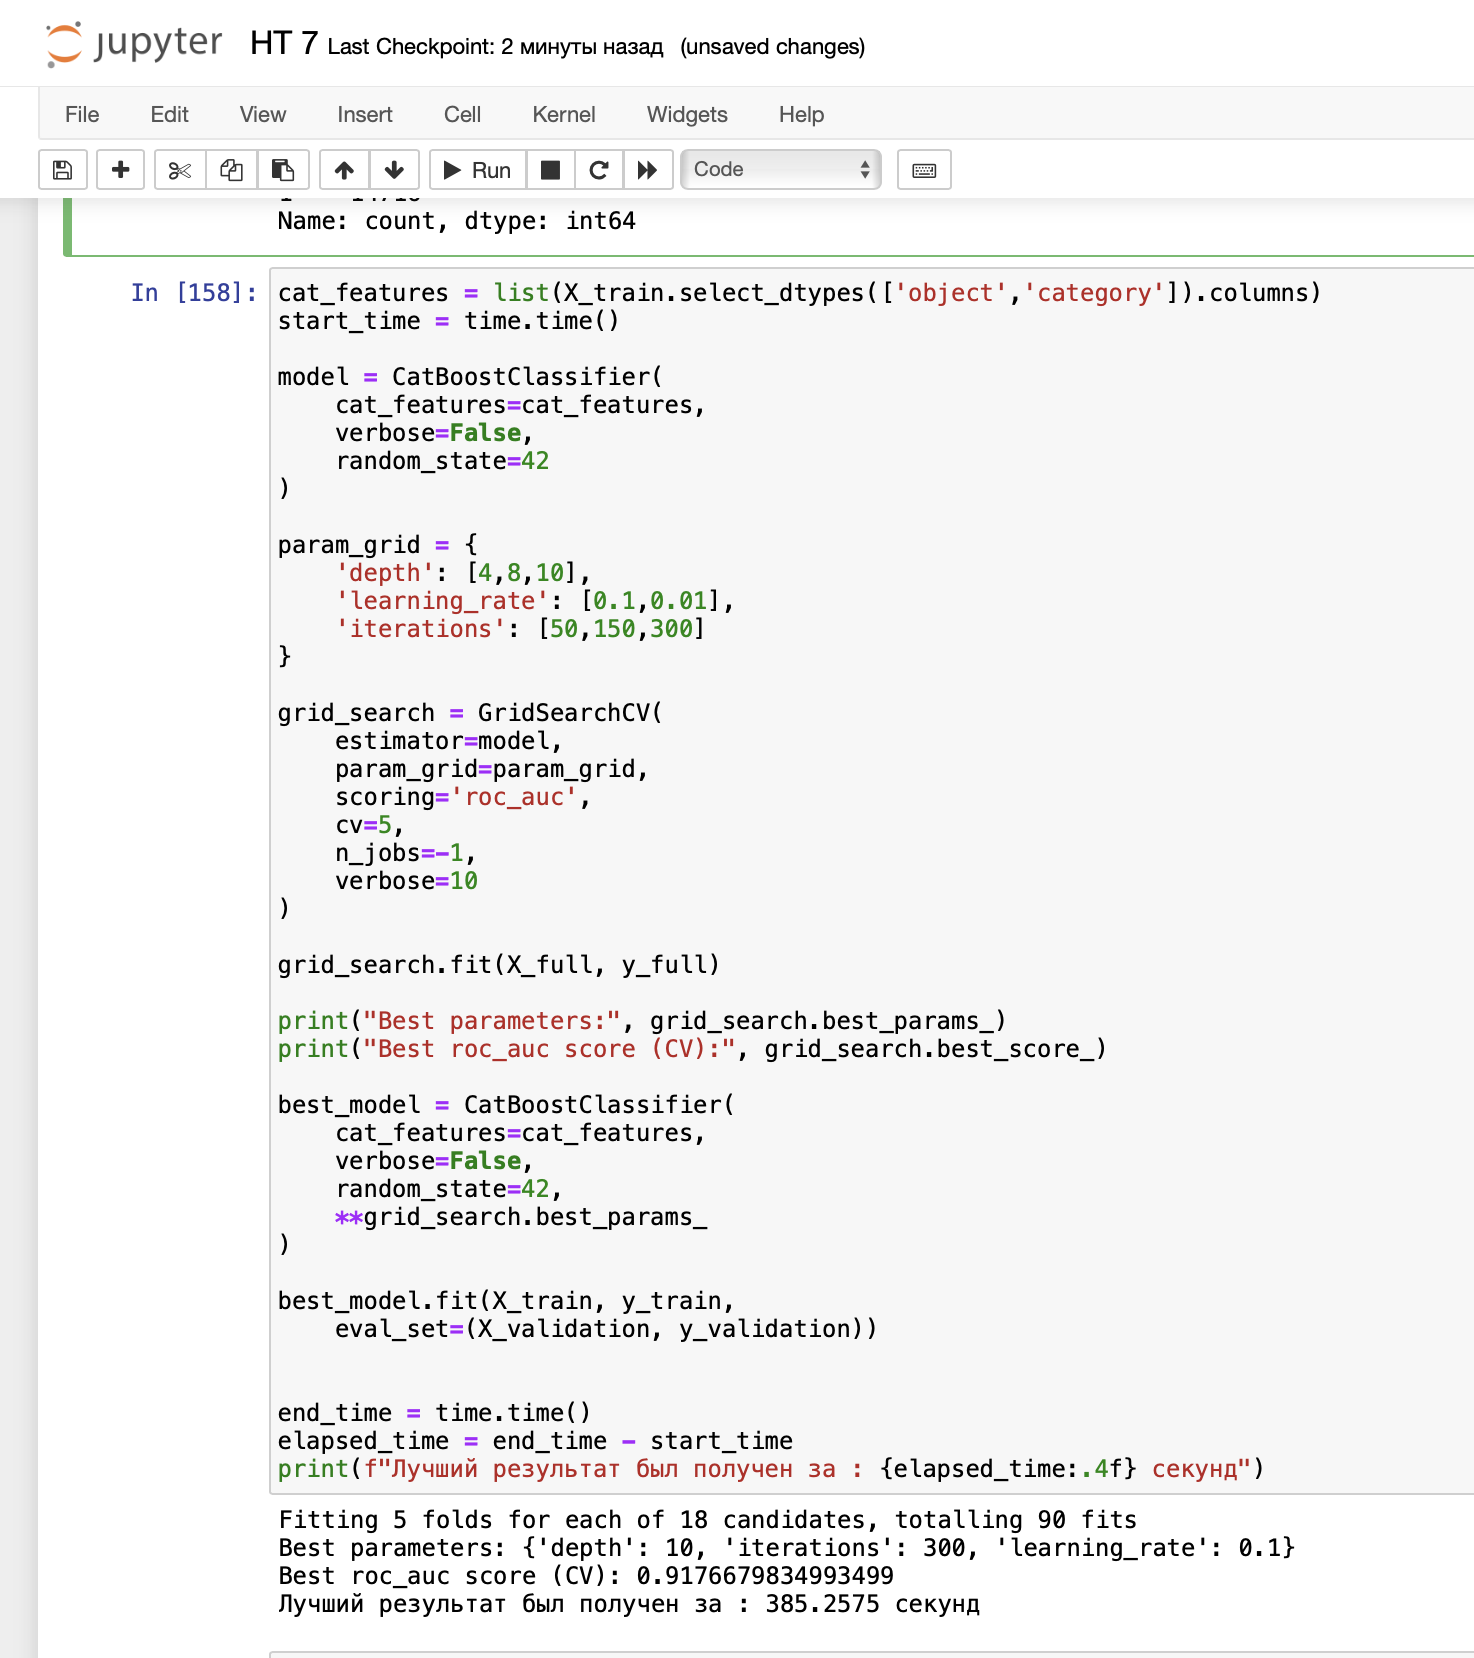

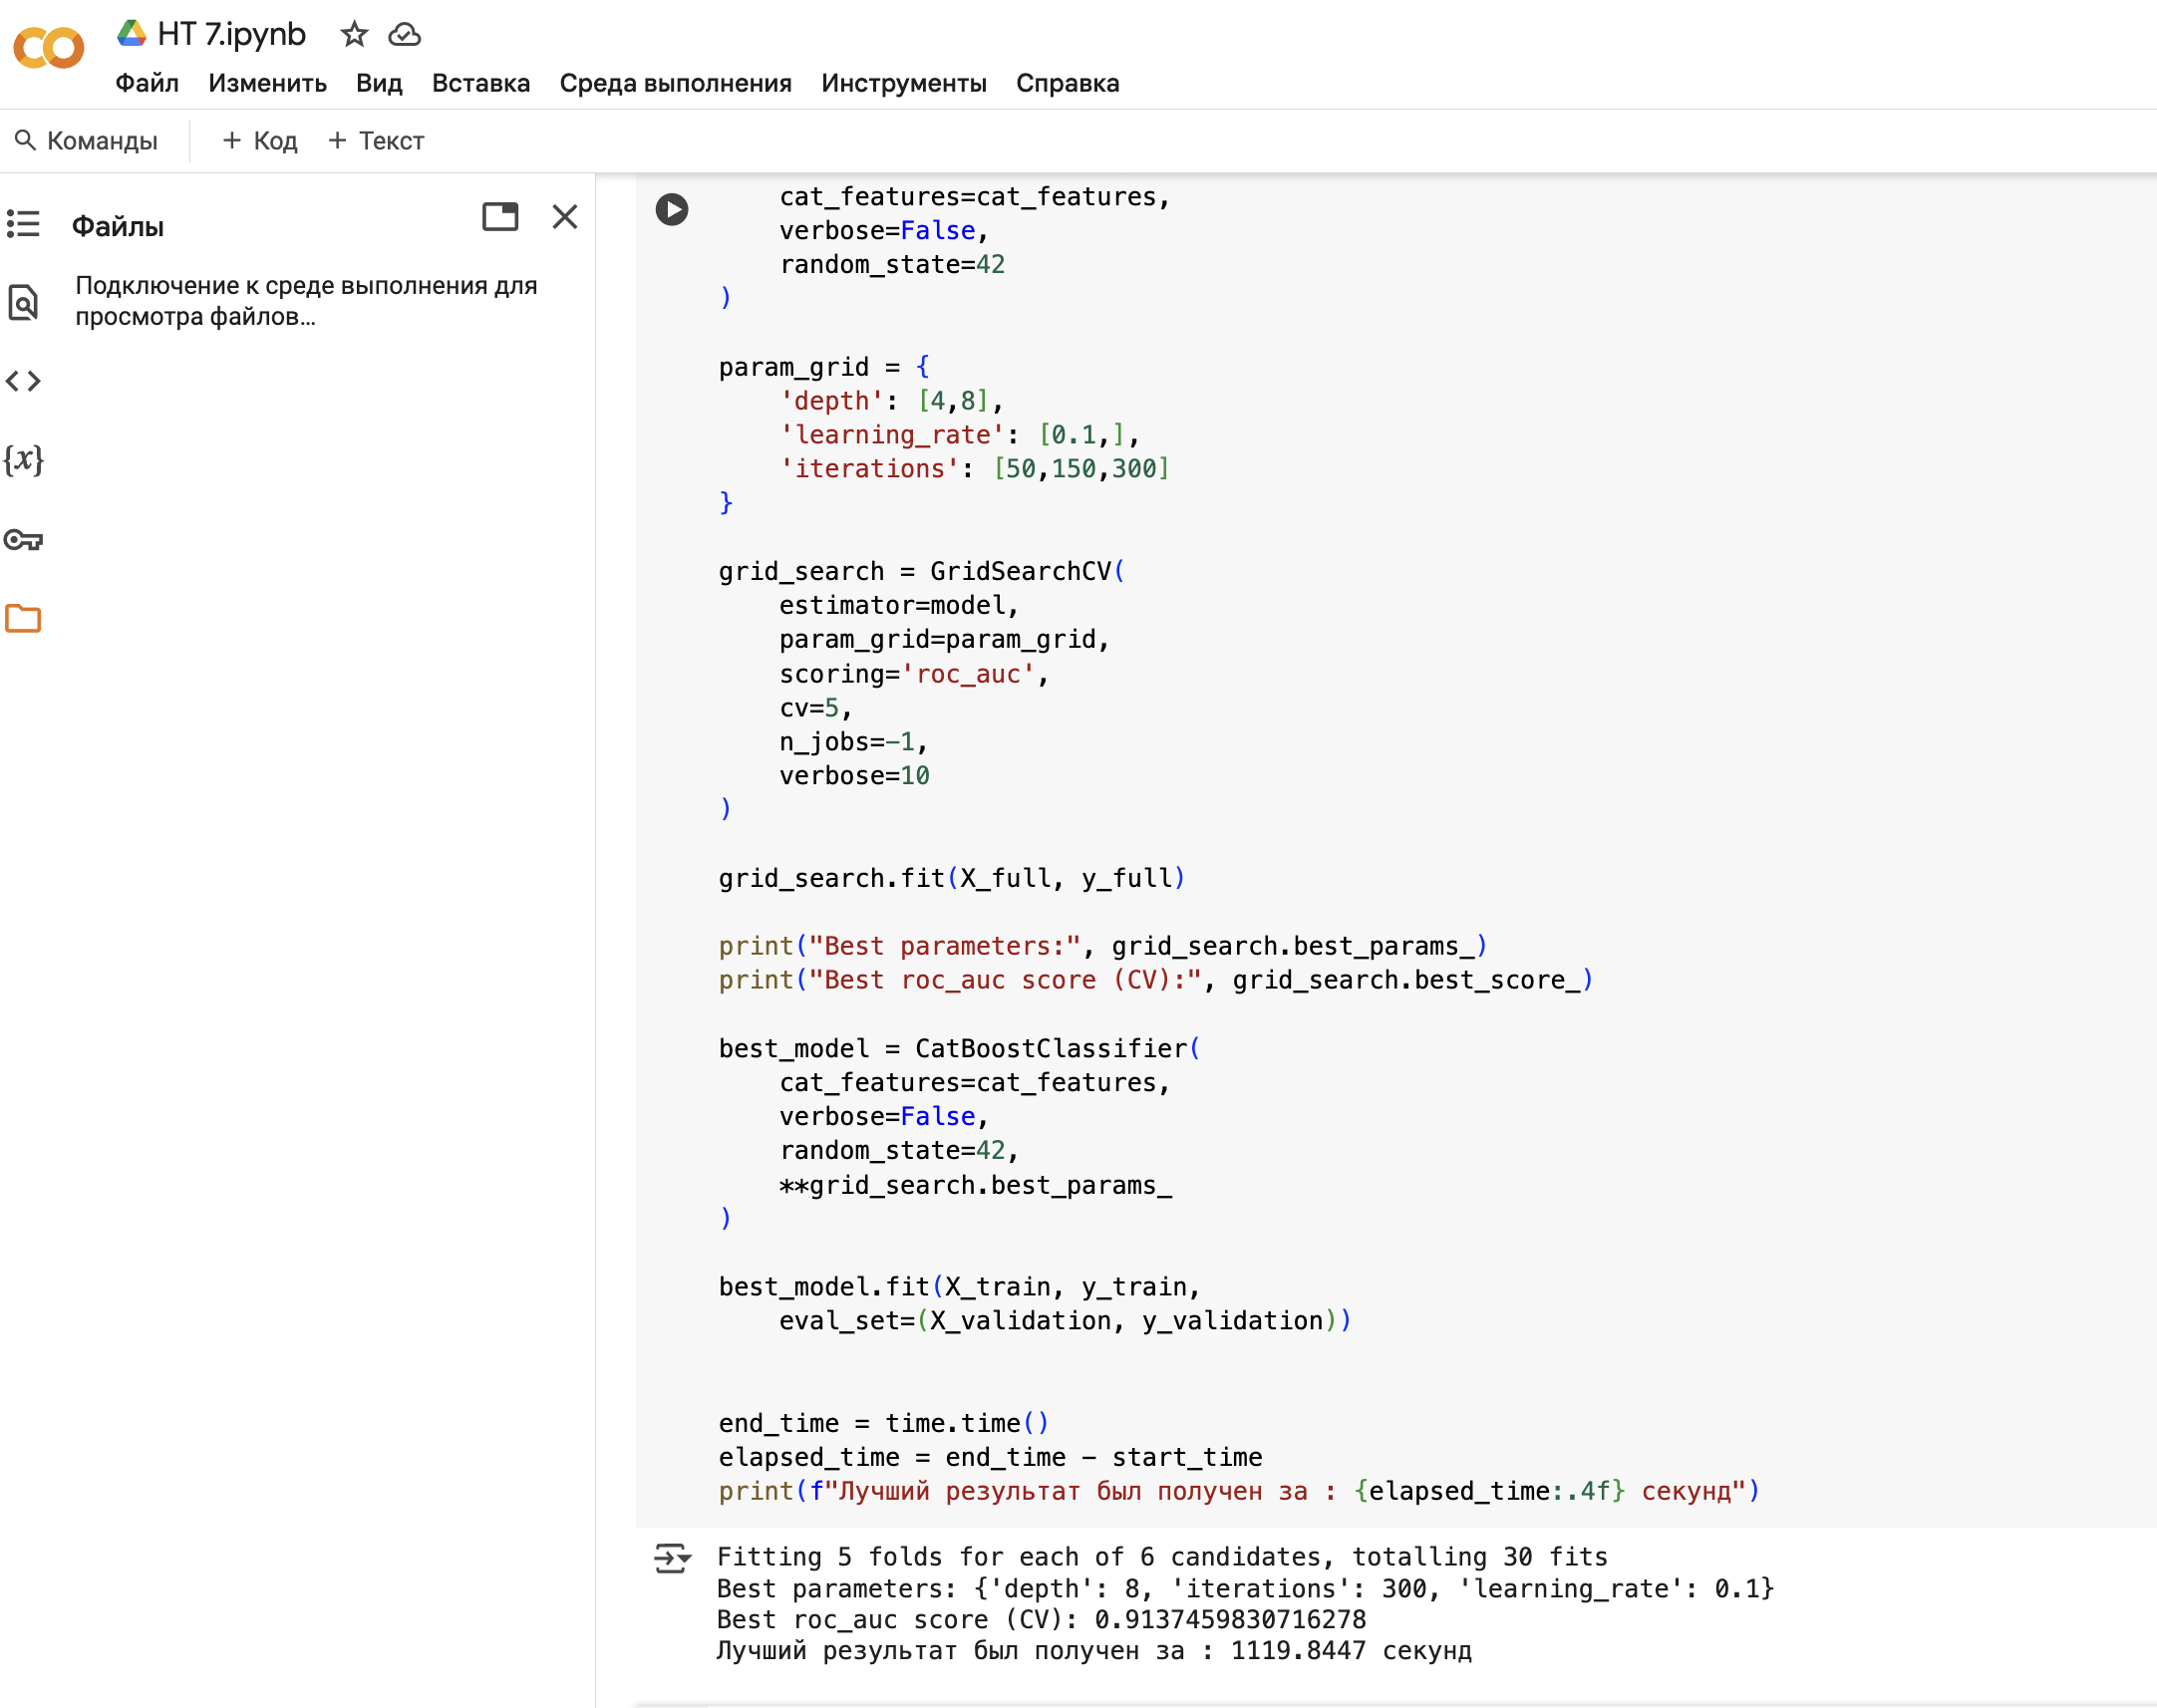

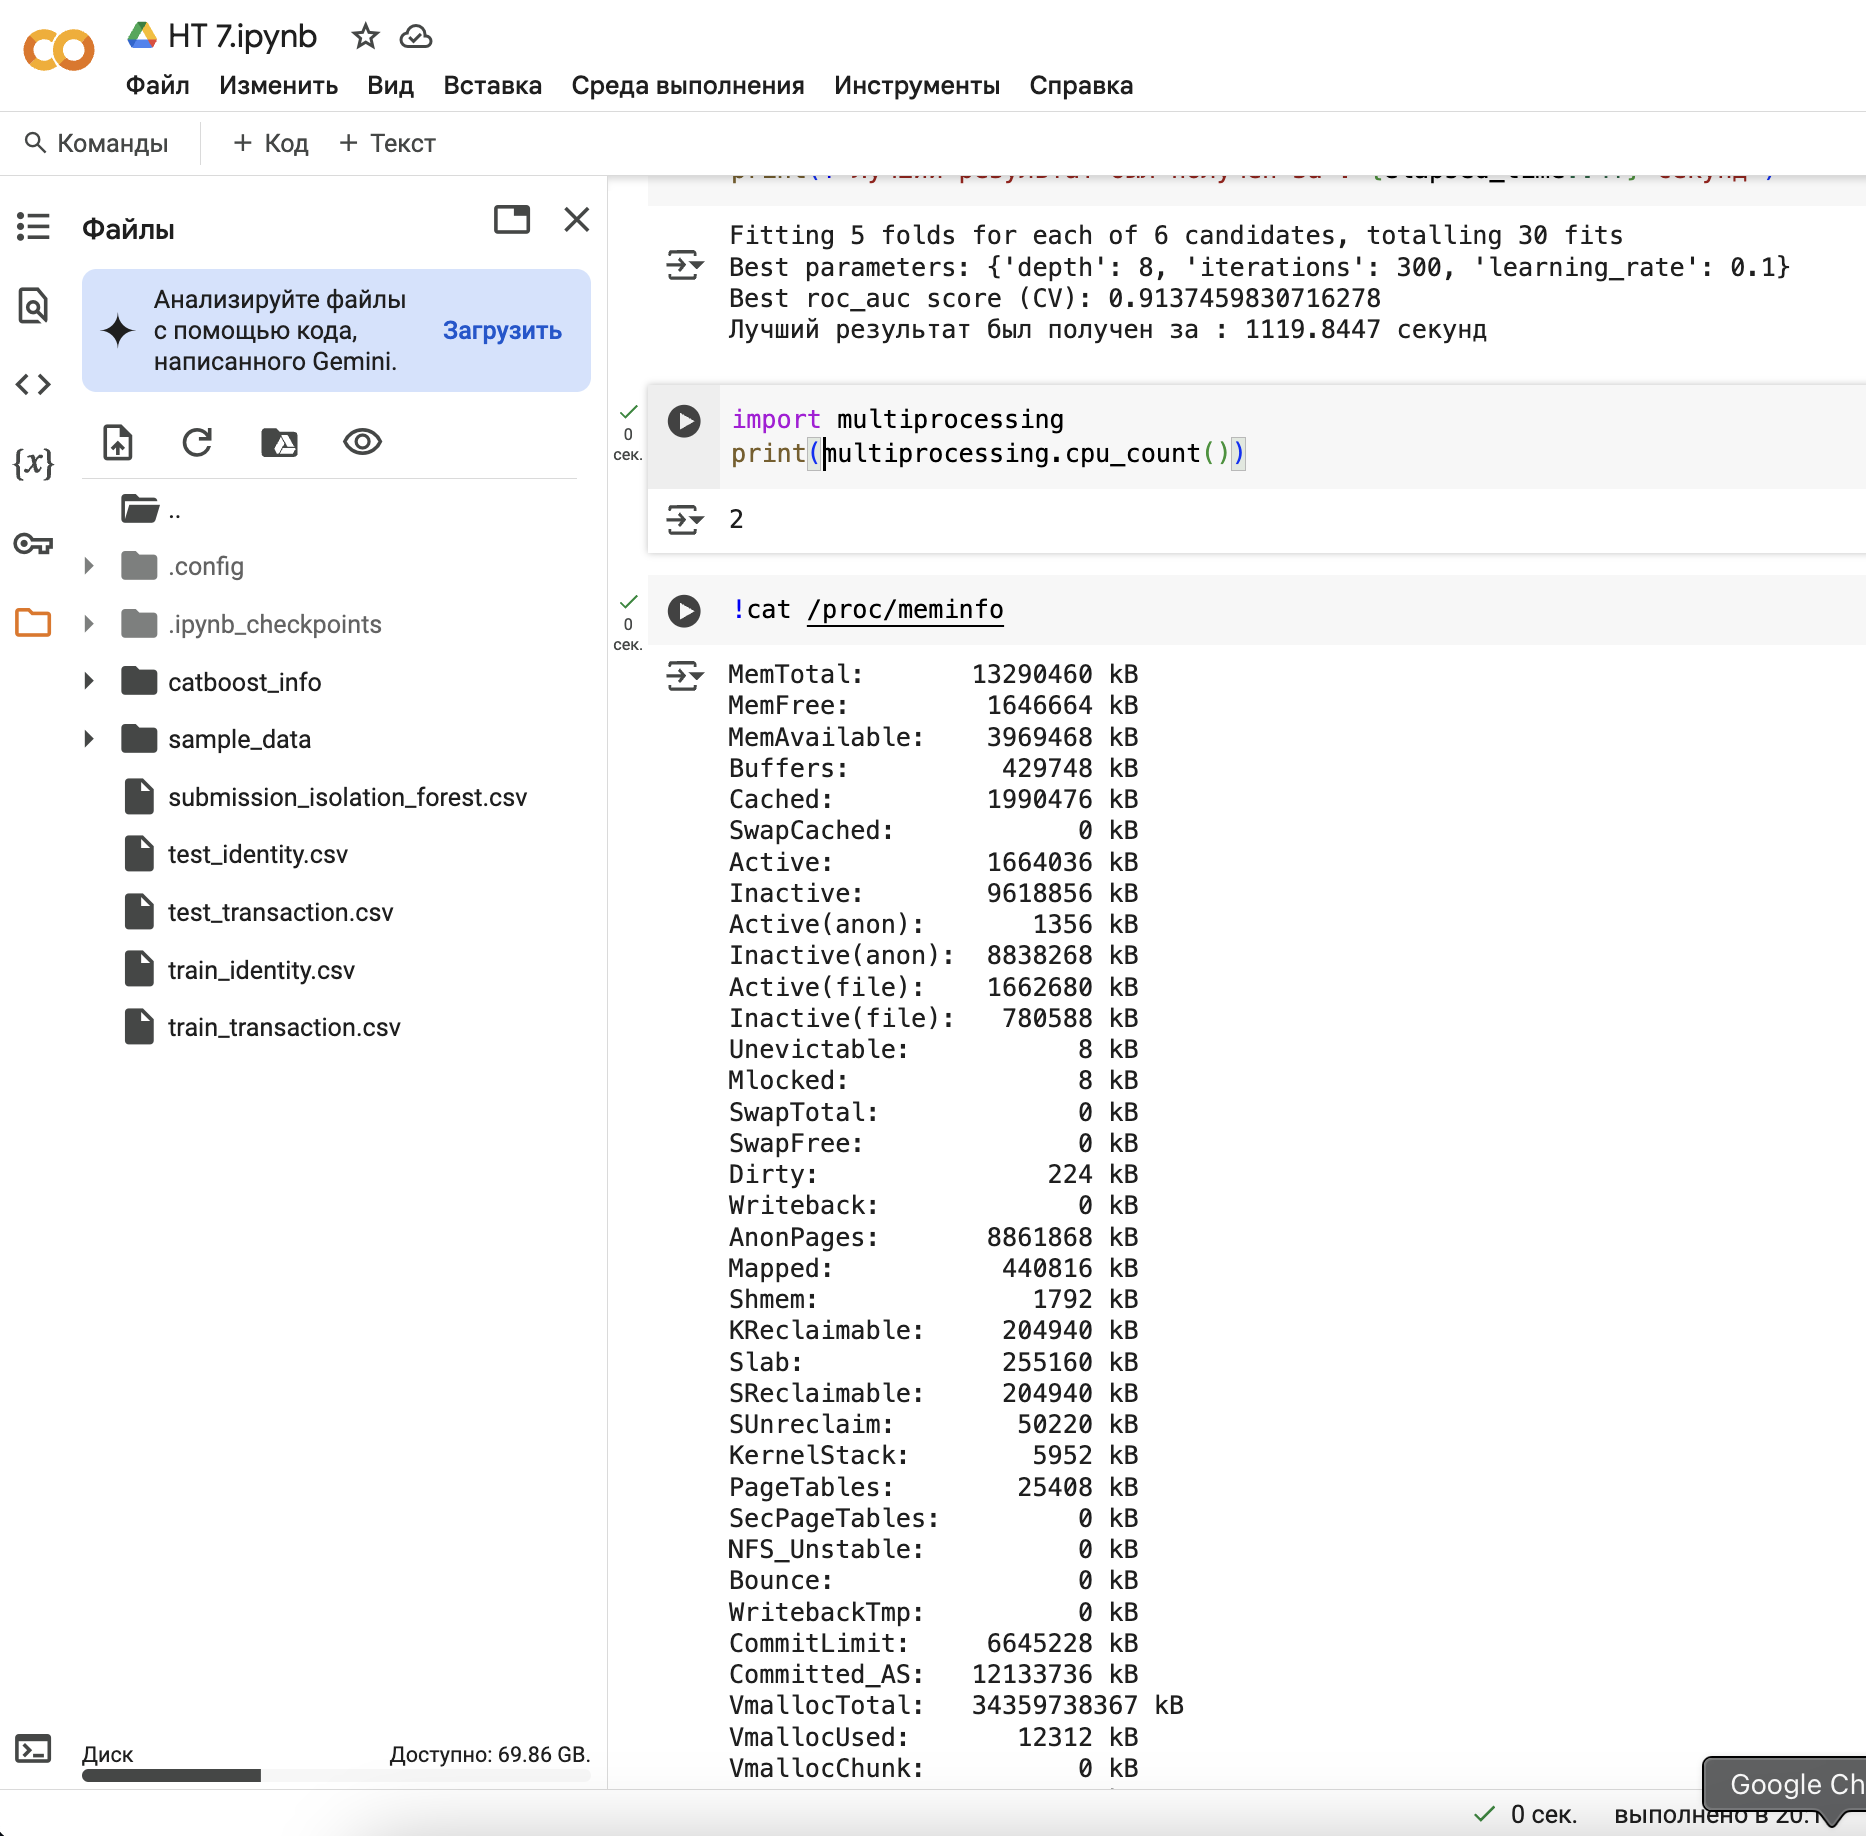